## Part I: Replicating Models

### Setup

In [150]:
#Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import minimize
from scipy.stats import poisson, nbinom, chi2
from math import factorial, log, exp
from scipy.special import gammaln, factorial

In [151]:
#Mount Drive [to delete]
from google.colab import files
from google.colab import drive
#drive.mount('/content/drive')


In [152]:
data1 = files.upload()

#Read in the dataset
df_billboard = pd.read_csv(r'billboard.csv')

df_billboard.head()

Saving billboard.csv to billboard (2).csv


,EXPOSURES,PEOPLE
0,0,48
1,1,37
2,2,30
3,3,24
4,4,20


### 1. The Poisson Model

#### a) Write code to estimate the parameters of the Poisson model using maximum likelihood estimation (MLE).

In [153]:
# Prepare the data for modeling
exposures = np.array(df_billboard['EXPOSURES'])
people = np.array(df_billboard['PEOPLE'])

Poisson PMF (Probability Mass Function) Formula

$$
P(X = k) = \frac{\lambda^k \, e^{-\lambda}}{k!}
$$

Given:
- \( lambda \): The average rate of events per interval.
- \( k\): The exact number of events.

##### 1. The Log-Likelihood (LL)

In [154]:
# lambda param: decision variable (λ)
# exposures (k): number of billboard exposure(s)
# people[i]: the number of people who experienced 'k number' of billboard exposure(s)

def LL_poisson(lambda_param, exposures, people):
    # Unpack lambda parameter
    lambda_param = float(lambda_param[0])

    # Initialize log-likelihood as a scalar
    ll = 0 #Used this approach vs. creating a list because it is computationally more efficient

    # Loop through each exposure level and its observed frequency
    for i in range(len(exposures)):
        k = exposures[i]
        count = people[i]

        '''
        Poisson Probability mass function (PMF) = P(x = k | lambda) = (lambda^k * exp(-lambda)) / k!
        '''
        # Calculate the log of the Poisson PMF (Probability Mass Function) for the current exposure level
        log_pmf = poisson.logpmf(k, lambda_param)

        # Weighted log-likelihood for this exposure level
        ll += count * log_pmf  # Multiply by the number of people (count) at this exposure level

    # Return the total negative log-likelihood
    return -ll # minimize for optmization


##### 2. Optimize

In [155]:
#Specify the initial guess for lambda
initial_lambda_guess =np.array([1])

In [156]:
# Maximize likelihood

# args = (exposures, people): Input parameters
# bounds = [(0.000001, None)]: Bounds for lambda to ensure it's positive
# tolerance: controls over the stopping criteria for the minimization
# options = 'ftol' (function tolerance): ensures that the function's value changes by less than than 1e-8 before stopping

# Run the optimization
result = minimize(LL_poisson,
                  initial_lambda_guess,
                  args=(exposures, people),
                  method='L-BFGS-B',
                  bounds=[(1e-10, None)],
                  tol = 1e-10,
                  options = {'ftol': 1e-8}
                  )

In [157]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 929.043882727306
        x: [ 4.456e+00]
      nit: 8
      jac: [-2.274e-05]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

#### b) Find estimated parameters and maximum value of the log-likelihood

In [158]:
# Extract the estimated lambda and MLE
lambda_mle = result.x[0]

#Convert to positive
max_log_likelihood = -result.fun

print(f"Estimated Lambda (λ): {lambda_mle}")
print(f"Maximum Log-Likelihood: {max_log_likelihood}")

Estimated Lambda (λ): 4.455999290455263
Maximum Log-Likelihood: -929.043882727306


#### c) Predict the number of people with 0, ..., 23 exposures based on the Poisson model.

In [159]:
# Predict the number of people for 0 - 23 exposures
exposures_pred = np.arange(0, 24)
total_people = sum(people)  # Assuming people is already defined in your environment
lambda_mle = lambda_mle  # Assuming lambda_mle is defined as the estimated lambda from MLE

# Calculate the predicted number of people for each exposure level
people_pred_poisson = total_people * (np.exp(-lambda_mle) * lambda_mle**exposures_pred / np.array([factorial(k) for k in exposures_pred]))

# Create a DataFrame to organize the data
df_predictions = pd.DataFrame({
    'Exposure Level': exposures_pred,
    'Predicted People': people_pred_poisson
})

# Display the DataFrame
print("Predictions of people with 0, ...,23 exposures based on the Poisson model")
df_predictions


Predictions of people with 0, ...,23 exposures based on the Poisson model


,Exposure Level,Predicted People
0,0,2.902178e+00
1,1,1.293210e+01
2,2,2.881273e+01
3,3,4.279649e+01
4,4,4.767529e+01
5,5,4.248821e+01
6,6,3.155457e+01
7,7,2.008674e+01
8,8,1.118831e+01
9,9,5.539456e+00


#### d) Explain how the predicted values are obtained using the case of 2 exposures (show your calculations).

In [160]:
sum(people)

250

In [161]:
k = 2
predicted_people_2_exposures = total_people * ((np.exp(-lambda_mle) * lambda_mle**k / factorial(k)))
print(f"Predicted number of people for 2 exposures: {predicted_people_2_exposures}")


Predicted number of people for 2 exposures: 28.812725109282518


Poisson PMF (Probability Mass Function) Formula

$$
P(X = k) = \frac{\lambda^k \, e^{-\lambda}}{k!}
$$

Given:
- \( λ = 4.456 \): The average rate of events per interval.
- \( k = 2 \): The exact number of events.

$$
P(X = 2) = 250 * \frac{4.456^2 \cdot e^{-4.456}}{2!} ≈ 28.813
$$


#### e) Graph the original and predicted number of exposures (number of people on the y-axis and the numbers of exposures on the x-axis).

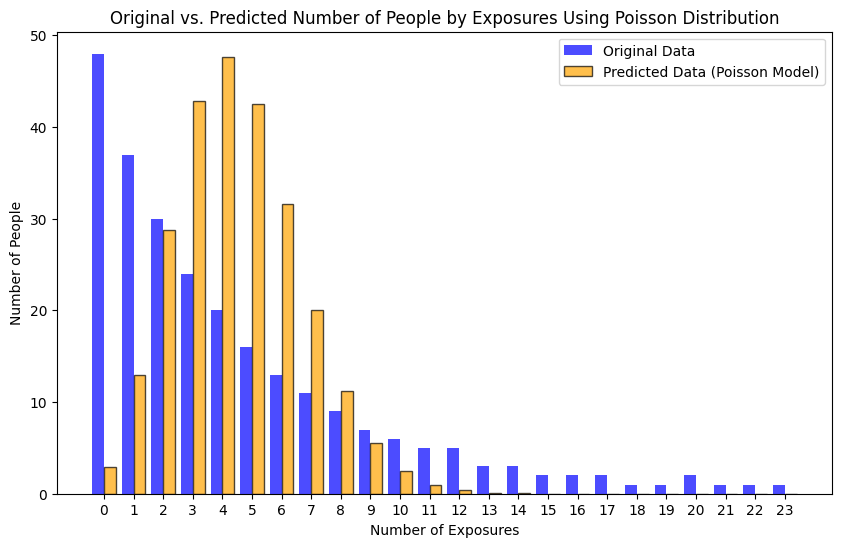

In [162]:
plt.figure(figsize=(10, 6))

# Plot original data as bars
plt.bar(exposures, people, label='Original Data', alpha=0.7, color='blue', width=0.4, align='center')

# define position of bars on x-axis
ind = np.arange(len(exposures))

# define the width of a bar
width = 0.4

# Plot predicted data as bars with a slight offset to avoid overlap
plt.bar(exposures_pred + 0.4, people_pred_poisson, label='Predicted Data (Poisson Model)', alpha=0.7, color='orange', edgecolor = 'black', width=0.4, align='center')

# Labeling the axes and adding a title
plt.xlabel('Number of Exposures')
plt.ylabel('Number of People')
plt.legend()
xticks = plt.xticks(ind + width / 2, df_billboard['EXPOSURES'])
plt.title('Original vs. Predicted Number of People by Exposures Using Poisson Distribution')
plt.show()

### 2. The NBD Model

Negative Binomial distribution PMF Formula

$
P(X = k) = \frac{\Gamma(n + k)}{\Gamma(n) \cdot k!} \cdot \left( \frac{\alpha}{\alpha+ 1} \right)^{n} \cdot \left( \frac{1}{\alpha + 1} \right)^k
$

#### a) Write code (for the same dataset) to estimate the parameters of the NBD model using MLE.

Report your code, the estimated parameters and the maximum value of the log-likelihood.

##### 1.  Log-Likelihood

In [163]:
# n, alpha: shape and scale parameters for the gamma distribution
# exposures: size of the number of exposures
# people: the number of people with the corresponding number of billboard exposures

def NLL_nbd(params, exposures, people):
  # unpack parameters
  n, alpha = params # shape and scale parameters for gamma distribution
  (nb_r, nb_p) = (n, alpha / (alpha + 1)) # parameters in the negative binomial distribution

  # calculate log probabilities for all exposures at once
  log_prob = nbinom.logpmf(exposures, nb_r, nb_p, loc = 0)

  # calculate log-likelihood for each exposure count
  ll = people * log_prob

  # sum the negative log-likelihood
  nll = -np.sum(ll)

  return nll

##### 2. Optimize

In [164]:
# Initial guesses for parameters
params = np.array((1,1)) # initial guess for parameters

nbd_result = minimize(NLL_nbd, # minimize the negative log-likelihood (equivalent to maximizing the log-likelihood)
                args = (exposures, people), # input parameters (not to be altered by the solver)
                x0 = params, # initial guess for lambda
                bounds = [(0.000001, None), (0.000001, None)], # bounds for decision variables
                tol = 1e-10, # convergence tolerance
                options = {'ftol': 1e-8} # fractional tolerance
                )

##### 3. Find estimated parameters and maximum value of the log-likelihood

In [165]:
# MLE parameters
mle_params_nbd = nbd_result.x
print(f'Estimated n: {mle_params_nbd[0]}\nEstimated α: {mle_params_nbd[1]}')

# maximum value of log-likelihood
mll_nbd = -nbd_result.fun
print(f'Maximum Log-Likelihood: {mll_nbd}')

Estimated n: 0.9692595079230317
Estimated α: 0.2175177961781643
Maximum Log-Likelihood: -649.688827483665


#### b) Predict the number of people with 0, …, 23 exposures based on the NBD model.

In [166]:
n_mle = mle_params_nbd[0]
alpha_mle = mle_params_nbd[1]

In [167]:
# Prediction for the number of people with different purchase counts
# Calculate expected people count for purchase levels 0 to 23
exposures_pred = np.arange(0, 24)
people_pred = (np.exp(gammaln(exposures_pred + n_mle) - gammaln(n_mle) - gammaln(exposures_pred + 1)) *
               (alpha_mle / (alpha_mle + 1))**n_mle * (1 / (alpha_mle + 1))**exposures_pred)

# Scale predictions to the total number of people observed
total_people = sum(people)
people_pred_scaled = total_people * people_pred

# Create a DataFrame for predictions
df_predictions = pd.DataFrame({
    'Purchase Count': exposures_pred,
    'Predicted People': people_pred_scaled
})

print("\nPredicted number of people for each purchase count level based on NBD:")
print(df_predictions)


Predicted number of people for each purchase count level based on NBD:
    Purchase Count  Predicted People
0                0         47.092611
1                1         37.490180
2                2         30.319020
3                3         24.647152
4                4         20.088196
5                5         16.397864
6                6         13.399271
7                7         10.957071
8                8          8.964935
9                9          7.338138
10              10          6.008602
11              11          4.921333
12              12          4.031749
13              13          3.303619
14              14          2.707447
15              15          2.219186
16              16          1.819212
17              17          1.491495
18              18          1.222938
19              19          1.002826
20              20          0.822399
21              21          0.674483
22              22          0.553208
23              23          0.453766


#### c) Explain how the predicted values are obtained using the case of 2 exposures (show your calculations).

In [168]:
# Given parameters: exposure level and observed total number of people
k = 2  # number of exposures we want to predict
total_people = sum(people)  # total observed people, as in the previous code

# Parameters from MLE
n_mle = mle_params_nbd[0]  # Estimated n parameter from MLE
alpha_mle = mle_params_nbd[1]  # Estimated α parameter from MLE

# Calculate predicted number of people with exactly `k` exposures using Negative Binomial formula
predicted_people_2 = total_people * np.exp(
    gammaln(k + n_mle) - gammaln(n_mle) - gammaln(k + 1) +
    n_mle * np.log(alpha_mle / (alpha_mle + 1)) +
    k * np.log(1 / (alpha_mle + 1))
)

print(f"Predicted number of people for 2 exposures (NBD): {predicted_people_2}")

Predicted number of people for 2 exposures (NBD): 30.319020311761253


Negative Binomial distribution PMF Formula

$
P(X = k) = \frac{\Gamma(n + k)}{\Gamma(n) \cdot k!} \cdot \left( \frac{\alpha}{\alpha+ 1} \right)^{n} \cdot \left( \frac{1}{\alpha + 1} \right)^k
$

Predict values of k = 2 exposures:
-  size parameter **n** (shape of distribution) = 0.96926 \: number of trials until (X=k)
- scale/ dispersion parameter **α** (spread or how much variance deviates from mean)
  - n = 0.96926
  - α = 0.21752


$P(X = 2) = 250 \times \frac{Γ(0.96926)}{Γ(0.96926) \times 2!} \times \big(\frac{0.21752}{0.21752
 + 1}\big)^{0.96926} \times \big(\frac{1}{0.21752 + 1}\big)^{2} ≈ 30.319$

#### d) Graph the original and predicted numbers of exposures.

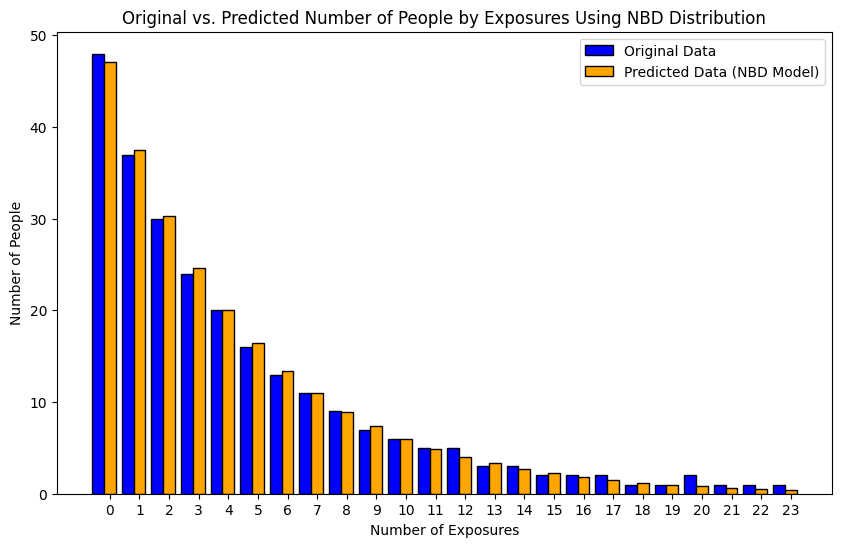

In [169]:
# Set up bar width for side-by-side placement
bar_width = 0.4

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(exposures - bar_width/2, people, bar_width, color='blue', edgecolor='black', label='Original Data')
plt.bar(exposures + bar_width/2, people_pred_scaled, bar_width, color='orange', edgecolor='black', label='Predicted Data (NBD Model)')

# Labeling
plt.xlabel('Number of Exposures')
plt.ylabel('Number of People')
plt.title('Original vs. Predicted Number of People by Exposures Using NBD Distribution')
xticks = plt.xticks(ind + bar_width / 2, df_billboard['EXPOSURES'])
plt.legend()
plt.show()

#### e) Evaluate the NBD model vis-à-vis the Poisson model; explain which is better and why.

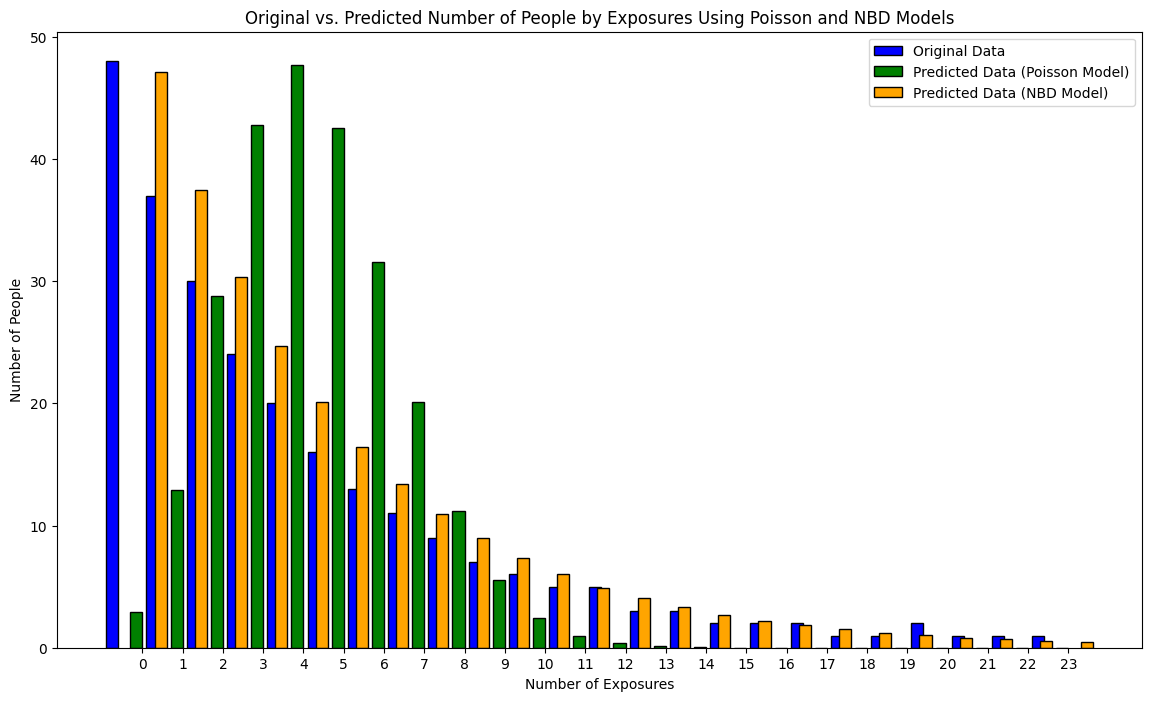

In [170]:
# Plotting side-by-side comparison of Poisson and NBD models
bar_width = 0.3

plt.figure(figsize=(14, 8))

# Plot original data
plt.bar(exposures - 0.6, people, bar_width, color='blue', edgecolor='black', label='Original Data')

# Plot Poisson model predictions
plt.bar(exposures_pred, people_pred_poisson, bar_width, color='green', edgecolor='black', label='Predicted Data (Poisson Model)')

# Plot NBD model predictions
plt.bar(exposures + 0.6, people_pred_scaled, bar_width, color='orange', edgecolor='black', label='Predicted Data (NBD Model)')

# Labeling the axes and adding a title
plt.xlabel('Number of Exposures')
plt.ylabel('Number of People')
xticks = plt.xticks(ind + bar_width / 2, df_billboard['EXPOSURES'])
plt.title('Original vs. Predicted Number of People by Exposures Using Poisson and NBD Models')
plt.legend()

plt.show()

### 3. The Poisson Regression

In Poisson regression, the expected count \( λ \) for observation \( i \) is modeled as:

$$
\lambda_i = \exp(\beta_0 + \beta_1 x_1^i + \beta_2 x_2^i + \beta_3 x_3^i + \beta_4 x_4^i)
$$

where:
- \( λ \) is the expected count of events for observation \( i \).
- \( β0 \) is the intercept term.
- \( β1, β2, β3, β4 \) are coefficients corresponding to each explanatory variable \( x1, x2, x3, x4 \).
- \( x_j^i \) represents the value of the \( j \)-th variable for observation \( i \).

#### a) Estimate all relevant parameters for Poisson regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood.

In [171]:
#Read in the dataset
data2= files.upload()
kc = pd.read_csv('khakichinos.csv')

kc.head()

Saving khakichinos.csv to khakichinos (2).csv


,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize
0,1,0,11.379394,1,3.871201,2
1,2,5,9.769956,1,4.043051,1
2,3,0,11.082143,0,3.332205,2
3,4,0,10.915088,1,3.951244,3
4,5,0,10.915088,1,2.833213,3


##### 1. Log Likelihood

In [172]:
# Calculated more efficienctly using Vectorized Calculations & Direct Summation

# Prepare input variables
X = kc.drop(['ID', 'NumberofVisits'], axis=1).values  # Drop ID and target column, convert to numpy array
y = kc['NumberofVisits'].values  # Target variable
params = np.ones(X.shape[1] + 1)  # Initial guess for parameters

# Optimized Negative Log-Likelihood function for Poisson regression
def NLL_poisson_reg(params, X, y):
    # Extract lambda_0 and betas
    lambda_0, *betas = params
    betas = np.array(betas)  # Convert to numpy array for vectorized operations

    # Calculate lambdas for each record using vectorized operations
    lambdas = lambda_0 * np.exp(X @ betas)  # Vectorized calculation of lambdas

    # Vectorized negative log-likelihood calculation for all records at once
    nll = -np.sum(poisson.logpmf(y, lambdas))  # Direct summation of log-likelihoods

    return nll

##### 2. Optimize

In [173]:
# Minimize the negative log-likelihood
soln_poisson_reg = minimize(
    NLL_poisson_reg,           # Minimize the NLL function
    args=(X, y),               # Arguments for the NLL function
    x0=params,                 # Initial guess for parameters
    bounds=[(0.000001, None)] + [(None, None)] * X.shape[1],  # Parameter bounds
    tol=1e-10,                 # Convergence tolerance
    options={'ftol': 1e-8}     # Fractional tolerance
)

##### 3. Find estimated parameters and maximum value of the log-likelihood

In [174]:
# Extract MLE parameters for Poisson regression
mle_params_poisson_reg = soln_poisson_reg.x

# Print estimated parameters
print(f'Estimated lambda0: {mle_params_poisson_reg[0]}')
for i in range(1, len(mle_params_poisson_reg)):
    print(f'Estimated beta{i}: {mle_params_poisson_reg[i]}')

# Calculate and print maximum value of log-likelihood
mll_poisson_reg = -soln_poisson_reg.fun
print(f'Maximum Log-Likelihood: {mll_poisson_reg}')

Estimated lambda0: 0.04366663432727533
Estimated beta1: 0.09414793754474536
Estimated beta2: 0.004408396305883515
Estimated beta3: 0.5886545074626335
Estimated beta4: -0.035947201791870984
Maximum Log-Likelihood: -6291.496840323027


In [175]:
# Fit Poisson regression model
X = sm.add_constant(X)  # Add intercept
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2728
Model:                            GLM   Df Residuals:                     2723
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6291.5
Date:                Mon, 11 Nov 2024   Deviance:                       10745.
Time:                        00:43:28   Pearson chi2:                 4.10e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06187
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1262      0.406     -7.702      0.0

#### b)  Predict the number of people with 0, ..., 23 visits based on the Poisson regression.

In [176]:
#Extract estimated coefficients for λ calculation
estimated_params = poisson_model.params

#Calculate λ for each observation
lambda_vals = np.exp(np.dot(X, estimated_params))

In [177]:
#Generate predictions for each exposure level from 0 to 23
exposure_range = np.arange(24)  # Range of exposures to predict (0 to 23)
predicted_counts = []

for k in exposure_range:
    # Calculate the expected number of people with exactly `k` exposures
    # by summing Poisson probabilities for `k` exposures across all observations
    expected_count_k = np.sum(poisson.pmf(k, mu=lambda_vals))
    predicted_counts.append(expected_count_k)

In [178]:
# Create a DataFrame for easier viewing
predicted_counts_poissonreg_df = pd.DataFrame({
    'Number of Visits': exposure_range,
    'Predicted Number of People': predicted_counts
})

# Display the predicted counts DataFrame
predicted_counts_poissonreg_df

,Number of Visits,Predicted Number of People
0,0,1.087056e+03
1,1,9.680819e+02
2,2,4.633290e+02
3,3,1.566412e+02
4,4,4.161370e+01
5,5,9.189184e+00
6,6,1.746106e+00
7,7,2.922980e-01
8,8,4.384556e-02
9,9,5.969776e-03


#### c) Explain how the predicted values are obtained using the case of 2 exposures (show your calculations).

In [179]:
#Predict the expected number of people with exactly 2 exposures
k = 2

In [180]:
# Calculate the probability of exactly 2 exposures for each observation
probability_2_exposures = poisson.pmf(k, mu=lambda_vals)

# Sum the probabilities across all observations to get the expected count
predicted_count_2_exposures = np.sum(probability_2_exposures)

# Display the result
print(f"Predicted number of people with exactly {k} exposures: {predicted_count_2_exposures}")

Predicted number of people with exactly 2 exposures: 463.32903284742633


Step-by-Step Calculation of P(X = 2) in Poisson Regression

1. **Calculate the Expected Count \( λi \)**

   For each observation \( i \), the expected count \(λi\) is given by:

   $$
   \lambda_i = \lambda_0 \times \exp(\beta_1 x_{1,i} + \beta_2 x_{2,i} + \beta_3 x_{3,i} + \beta_4 x_{4,i})
   $$

   where:
   - λ0 ≈ 0.0437
   - β1 ≈ 0.0941
   - β2 ≈ 0.0044
   - β3 ≈ 0.5887
   - β4 ≈ -0.0359

2. **Compute the Probability of Exactly 2 Exposures**

   We use the Poisson probability mass function (PMF) to compute the probability that each individual has exactly 2 exposures, given by:

   $$
   P(X = 2) = \frac{\lambda_i^2 \exp(-\lambda_i)}{2!}
   $$

3. **Calculate P(X = 2) by Summation**

   $$
   P(X = 2) ≈ 463.329
   $$


 #### d) Graph the original and predicted numbers of visits.

In [181]:
# Calculate actual counts from the dataset
actual_counts = kc['NumberofVisits'].value_counts().sort_index()
actual_counts = actual_counts.reindex(exposure_range, fill_value=0)

# Add actual counts to the DataFrame for easy plotting
predicted_counts_poissonreg_df['Actual Number of People'] = actual_counts.values

# Display the predicted counts DataFrame
predicted_counts_poissonreg_df

,Number of Visits,Predicted Number of People,Actual Number of People
0,0,1.087056e+03,2046
1,1,9.680819e+02,318
2,2,4.633290e+02,129
3,3,1.566412e+02,66
4,4,4.161370e+01,38
5,5,9.189184e+00,30
6,6,1.746106e+00,16
7,7,2.922980e-01,11
8,8,4.384556e-02,9
9,9,5.969776e-03,10


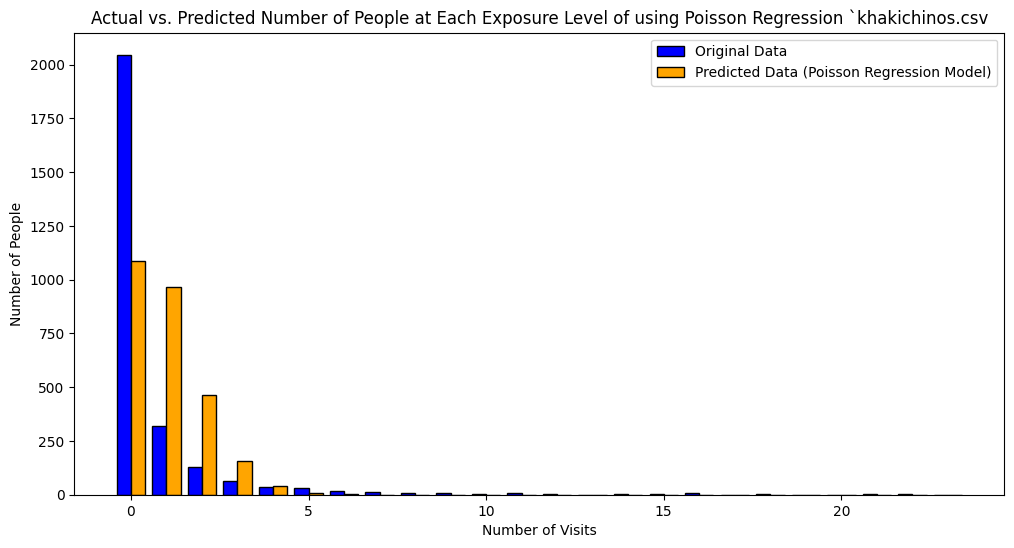

In [182]:
# Plotting the side-by-side bar chart with specified colors and edge colors
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Width of the bars

# Plot bars for actual and predicted counts
ax.bar(predicted_counts_poissonreg_df['Number of Visits'] - bar_width/2,
       predicted_counts_poissonreg_df['Actual Number of People'],
       bar_width,
       color='blue',
       edgecolor='black',
       label='Original Data')

ax.bar(predicted_counts_poissonreg_df['Number of Visits'] + bar_width/2,
       predicted_counts_poissonreg_df['Predicted Number of People'],
       bar_width,
       color='orange',
       edgecolor='black',
       label='Predicted Data (Poisson Regression Model)')

# Labeling the chart
ax.set_xlabel('Number of Visits')
ax.set_ylabel('Number of People')
ax.set_title('Actual vs. Predicted Number of People at Each Exposure Level of using Poisson Regression `khakichinos.csv')
ax.legend()

# Show plot
plt.show()

### 4. The NBD Regression

#### a) Consider the khakichinos example again. Estimate all relevant parameters for NBD regression using MLE.
Report your code, the estimated parameters and the maximum value of the log-likelihood.

##### 1. Log likelihood

In [183]:
# params: 1) n, alpha 2) betas - coefficients of linear regression
# X: characteristic variables lninc, sex, lnage, hhsize
# y: number of visits for each person

def NLL_nbd_reg(params, X, y):
  # unpack parameters
  n, alpha, *betas = params # n, alpha, and the remaining parameters in betas

  # calculate exp(beta*X) for each record using matrix multiplication
  exp_betaX = np.exp(X @ np.array(betas)) # X @ betas gives the linear combination

  # calculate log-likelihood components
  p1 = gammaln(n + y) - gammaln(n) - gammaln(y + 1) # gamma(k+1) = k! -> gammaln(k+1) = ln(k!)
  p2 = n * (np.log(alpha) - np.log(alpha + exp_betaX))
  p3 = y * (np.log(exp_betaX) - np.log(alpha + exp_betaX))

  # sum the log-likelihood components
  ll = p1 + p2 + p3

  # sum the negative log-likelihood
  nll = -np.sum(ll)

  return nll

##### 2. Optimize

In [184]:
# Minimize the negative log-likelihood
X = kc.copy()
X = np.array(X.drop(['ID', 'NumberofVisits'], axis = 1))
y = np.array(kc['NumberofVisits'])
params = np.ones(X.shape[1] + 2) # initial guess for parameters

soln_nbd_reg = minimize(NLL_nbd_reg, # minimize the negative log-likelihood (equivalent to maximizing the log-likelihood)
                args = (X, y), # input parameters (not to be altered by the solver)
                x0 = params, # initial guess for parameters
                bounds = [(0.000001, None)] * 2 + [(None, None)] * X.shape[1], # bounds for decision variables
                tol = 1e-10, # convergence tolerance
                options = {'ftol': 1e-8} # fractional tolerance
                )

##### 3. Find estimated parameters and maximum value of the log-likelihood

In [185]:
# MLE parameters
mle_params_nbd_reg = soln_nbd_reg.x
print(f'Estimated n: {mle_params_nbd_reg[0]}\nEstimated alpha: {mle_params_nbd_reg[1]}\nEstimated beta1: {mle_params_nbd_reg[2]}\nEstimated beta2: {mle_params_nbd_reg[3]}\nEstimated beta3: {mle_params_nbd_reg[4]}\nEstimated beta4: {mle_params_nbd_reg[5]}')

# maximum value of log-likelihood
mll_nbd_reg = -soln_nbd_reg.fun
print(f'Maximum Log-Likelihood: {mll_nbd_reg}')

Estimated n: 0.1387430837007758
Estimated alpha: 8.21001222365052
Estimated beta1: 0.07331897132672696
Estimated beta2: -0.008887610236015187
Estimated beta3: 0.9027452705052837
Estimated beta4: -0.02425966719231504
Maximum Log-Likelihood: -2888.966127657608


#### b) Predict the number of people with 0, ..., 23 exposures based on the NBD regression.

In [186]:
def predict_nbd_reg(params, X, y, max_k=23):
    """
    Predict the expected number of people with each visit count from 0 to max_k using the NBD regression model.

    Parameters:
    - params: Estimated parameters from the NBD regression (n, alpha, betas).
    - X: Matrix of characteristic variables.
    - y: Actual number of visits for each person.
    - max_k: The maximum count of visits for prediction (default is 23).

    Returns:
    - A dictionary with visit counts (0 to max_k) as keys and the expected number of people as values.
    """
    # Extract parameters
    n, alpha, *betas = params
    betas = np.array(betas)  # Convert betas to a numpy array

    # Calculate exp(beta * X) for each record using matrix multiplication
    exp_betaX = np.exp(X @ betas)

    # Limit unique counts to the range [0, max_k]
    unique_counts = np.arange(0, max_k + 1)

    # Dictionary to store predictions for each k
    pred = {}

    # Calculate the probability p(x = k) for each record and sum up
    for k in unique_counts:
        # Summing the NBD probabilities across all individuals for the specific count k
        pred[k] = np.sum([nbinom.pmf(k, n, alpha / (alpha + exp_betaX_i), loc=0) for exp_betaX_i in exp_betaX])

    # Sort dictionary by visit count (although in range order, sorting ensures consistent output)
    pred = dict(sorted(pred.items()))

    return pred

# Example usage after defining `mle_params_nbd_reg`, `X`, and `y`:
pred_nbd_reg = predict_nbd_reg(mle_params_nbd_reg, X, y)
pred_nbd_reg

{0: 2062.24589422425,
 1: 245.16835326118394,
 2: 120.13083412432069,
 3: 73.98600690866414,
 4: 50.32490129681167,
 5: 36.21949216786912,
 6: 27.045676946850143,
 7: 20.730112465819317,
 8: 16.204190028050718,
 9: 12.86232946105067,
 10: 10.33690216066821,
 11: 8.392781433545416,
 12: 6.873310503896286,
 13: 5.670625146017768,
 14: 4.708423361132619,
 15: 3.931497813571591,
 16: 3.2991322760557082,
 17: 2.780800821410764,
 18: 2.3532893073737586,
 19: 1.9987227760649897,
 20: 1.7031854905974335,
 21: 1.4557378571005204,
 22: 1.2477047004597615,
 23: 1.0721525193206423}

In [187]:
# create a dataframe to store actual counts
actual_df = kc.groupby('NumberofVisits')['ID'].count().reset_index()
actual_df.columns = ['NumberofVisits', 'ActualVisitorCount']

# create a dataframe to store predicted counts
pred_df = pd.DataFrame({'NumberofVisits': list(pred_nbd_reg.keys()),
                        'PredictedVisitorCount': list(pred_nbd_reg.values())})

# merge actual and predicted counts on NumberofVisits
kc_nbd_reg = pd.merge(actual_df, pred_df, on = 'NumberofVisits', how = 'outer').fillna(0)

# combine groups with number of visits
kc_nbd_reg_combined = kc_nbd_reg.copy()
kc_nbd_reg_combined.loc[kc_nbd_reg_combined['NumberofVisits'] >= 23, 'NumberofVisits'] = 23
kc_nbd_reg_combined = kc_nbd_reg_combined.groupby('NumberofVisits').sum().reset_index()
kc_nbd_reg_combined

,NumberofVisits,ActualVisitorCount,PredictedVisitorCount
0,0,2046.0,2062.245894
1,1,318.0,245.168353
2,2,129.0,120.130834
3,3,66.0,73.986007
4,4,38.0,50.324901
5,5,30.0,36.219492
6,6,16.0,27.045677
7,7,11.0,20.730112
8,8,9.0,16.204190
9,9,10.0,12.862329


 #### d) Explain how the predicted values are obtained using the case of 2 exposures (show your calculations).

In [188]:
# unpack estimated parameters
mle_n_nbd_reg, mle_alpha_nbd_reg, *mle_betas_nbd_reg = mle_params_nbd_reg

# calculate estimated exp_betaX
mle_exp_betaX_nbd_reg = np.exp(X @ np.array(mle_betas_nbd_reg))

# predicted values for the case of 2 visits
k = 2

# sum up the probabilities of 2 visits for each exp(betaX)_i
pred_2_visits_nbd_reg = np.sum(nbinom.pmf(k, mle_n_nbd_reg, mle_alpha_nbd_reg / (mle_alpha_nbd_reg + mle_exp_betaX_nbd_reg)))
print(f'The predicted number of people for the case of 2 visits: {pred_2_visits_nbd_reg}.')

The predicted number of people for the case of 2 visits: 120.13083412432069.


Step-by-Step Calculation of P(X = 2) in NBD Regression

1. **Calculate the Expected Count \(λi\)**

   For each observation \(i\), the expected count \(λi\) is given by:

   $$
   \mu_i = \exp(\beta_1 x_{1,i} + \beta_2 x_{2,i} + \beta_3 x_{3,i} + \beta_4 x_{4,i})
   $$

   where:
   - β1 = 0.0733
   - β2 = -0.0089
   - β3 = 0.9027
   - β4 = -0.0243

2. **Compute the Probability of Exactly 2 Exposures**

   For each observation, we use the Negative Binomial probability mass function (PMF) to compute the probability that each individual has exactly 2 exposures, given by:

   $$
   P(X = 2) = \frac{\Gamma(n + 2)}{\Gamma(n) \times 2!} \times \big(\frac{\alpha}{\alpha + \mu_i}\big)^{n} \times \big(\frac{\mu_i}{\alpha + \mu_i}\big)^{2}
   $$
   
   where:
   - n = 0.1387
   - α = 8.2100

3. **Calculate P(X = 2) by Summation**

   We then sum up all the probabilities of exactly 2 exposures across all observations.
   $$
   P(X = 2) ≈ 120.131
   $$


 #### d) Graph the original and predicted numbers of exposures.

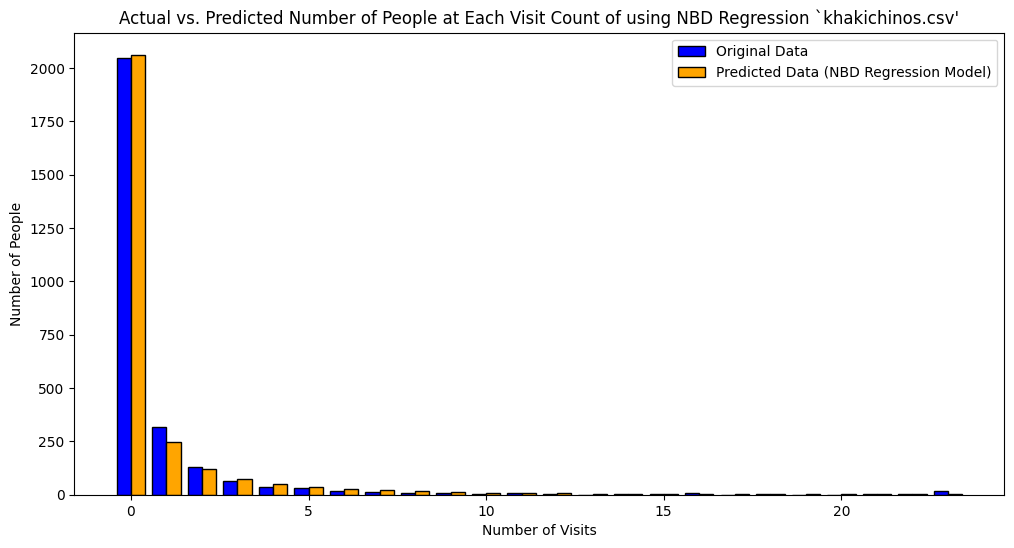

In [189]:
# Plotting the side-by-side bar chart with specified colors and edge colors
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Width of the bars

# Plot bars for actual and predicted counts
ax.bar(kc_nbd_reg_combined['NumberofVisits'] - bar_width/2,
       kc_nbd_reg_combined['ActualVisitorCount'],
       bar_width,
       color='blue',
       edgecolor='black',
       label='Original Data')

ax.bar(kc_nbd_reg_combined['NumberofVisits'] + bar_width/2,
       kc_nbd_reg_combined['PredictedVisitorCount'],
       bar_width,
       color='orange',
       edgecolor='black',
       label='Predicted Data (NBD Regression Model)')

# Labeling the chart
ax.set_xlabel('Number of Visits')
ax.set_ylabel('Number of People')
ax.set_title("Actual vs. Predicted Number of People at Each Visit Count of using NBD Regression `khakichinos.csv'")
ax.legend()

# Show plot
plt.show()

#### e) Evaluate the NBD regression vis-à-vis the Poisson regression; explain which is better and why.

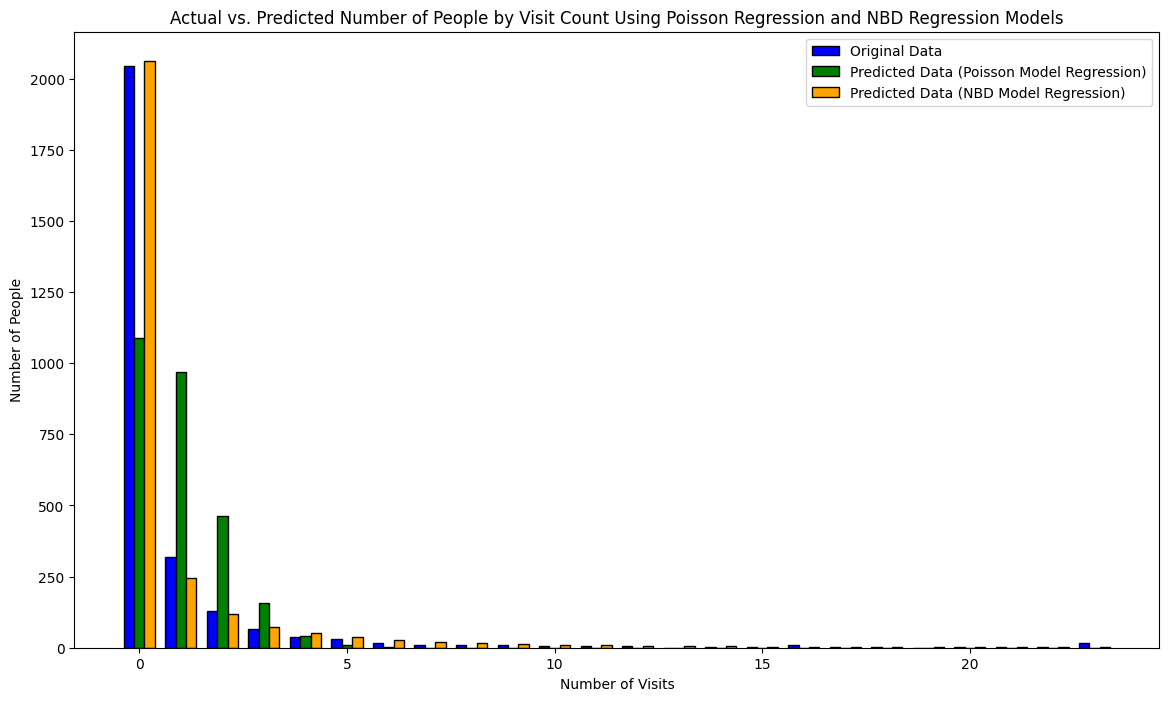

In [190]:
# Define bar width for side-by-side comparison
bar_width = 0.25

plt.figure(figsize=(14, 8))

# Plot actual data (Original Data)
plt.bar(kc_nbd_reg_combined['NumberofVisits'] - bar_width,
        kc_nbd_reg_combined['ActualVisitorCount'],
        bar_width,
        color='blue',
        edgecolor='black',
        label='Original Data')

# Plot Poisson regression model predictions
plt.bar(predicted_counts_poissonreg_df['Number of Visits'],
        predicted_counts_poissonreg_df['Predicted Number of People'],
        bar_width,
        color='green',
        edgecolor='black',
        label='Predicted Data (Poisson Model Regression)')

# Plot NBD regression model predictions
plt.bar(kc_nbd_reg_combined['NumberofVisits'] + bar_width,
        kc_nbd_reg_combined['PredictedVisitorCount'],
        bar_width,
        color='orange',
        edgecolor='black',
        label='Predicted Data (NBD Model Regression)')

# Labeling the axes and adding a title
plt.xlabel('Number of Visits')
plt.ylabel('Number of People')
plt.title('Actual vs. Predicted Number of People by Visit Count Using Poisson Regression and NBD Regression Models')
plt.legend()

# Display plot
plt.show()

## Part II: Analysis of New Data

### 1. Read `books01.csv`, with the structure of the dataset used in the *billboard exposures* example

In [191]:
#Read in the dataset
data3 = files.upload()
df_books = pd.read_csv(r'books.csv')

df_books.head()

Saving books.csv to books (2).csv


,userid,education,region,hhsz,age,income,child,race,country,domain,date,product,qty,price
0,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,20070101,LEONARD WOOLF A BIOGRAPHY BOOKS VICTORIA GLEND...,1,19.80
1,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,20070101,THE VIEW FROM CASTLE ROCK STORIES BOOKS ALICE ...,1,17.13
2,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,20070101,WILLIAM JAMES IN THE MAELSTROM OF AMERICAN MOD...,1,19.80
3,11519009,NaN,2.0,3,5.0,3,1,2,0,amazon.com,20070101,DRIVEN,1,2.00
4,11519009,NaN,2.0,3,5.0,3,1,2,0,amazon.com,20070101,CHOCOLATE COVERED FORBIDDEN FRUIT,1,3.88


#### a) Generate books01.csv
With the structure of the dataset used in the billboard exposures example (i.e., with only two columns – (i) the number purchases, and (ii) the number of people making the corresponding number of purchases)

In [192]:
#WITH ONLY B&N.com

# Step 1: Get a DataFrame with all unique user IDs
all_users = df_books[['userid']].drop_duplicates()

# Step 2: Filter for only rows where the domain is 'barnesandnoble.com' and aggregate total purchases by user
df_books_bn = df_books[df_books['domain'] == 'barnesandnoble.com']
user_purchases = df_books_bn.groupby('userid')['qty'].sum().reset_index()
user_purchases.columns = ['userid', 'total_purchases']  # Rename for clarity

# Step 3: Merge with all users to include those with 0 purchases
# Fill missing values in 'total_purchases' with 0 for users with no purchases
user_purchases = all_users.merge(user_purchases, on='userid', how='left').fillna({'total_purchases': 0})

# Step 4: Count the number of people (users) for each unique purchase count, including 0 purchases
books_summary = user_purchases['total_purchases'].value_counts().reset_index()
books_summary.columns = ['number_of_purchases', 'number_of_people']

# Step 5: Sort the DataFrame by number of purchases
books_summary = books_summary.sort_values(by='number_of_purchases').reset_index(drop=True)

# Print the result to verify
print(books_summary.head())

#Save to CSV
books_summary.to_csv("books01.csv", index=False)
print("books01.csv created!")


   number_of_purchases  number_of_people
0                  0.0              7639
1                  1.0               753
2                  2.0               362
3                  3.0               175
4                  4.0               126
books01.csv created!


In [193]:
# read in `books01.csv`
df_books01 = pd.read_csv(r'books01.csv')

# print the first and last 10 records
print(f'First 10 records of `books01.csv`:\n{df_books01.head(10)}')
print(f'Last 10 records of `books01.csv`:\n{df_books01.tail(10)}')

First 10 records of `books01.csv`:
   number_of_purchases  number_of_people
0                  0.0              7639
1                  1.0               753
2                  2.0               362
3                  3.0               175
4                  4.0               126
5                  5.0                82
6                  6.0                74
7                  7.0                30
8                  8.0                48
9                  9.0                31
Last 10 records of `books01.csv`:
    number_of_purchases  number_of_people
36                 46.0                 1
37                 47.0                 1
38                 50.0                 1
39                 56.0                 1
40                 58.0                 1
41                 62.0                 1
42                 63.0                 1
43                 83.0                 1
44                 86.0                 1
45                111.0                 1


#### b. Generate books02.csv

With the structure of the dataset used in the khakichinos example, with a new column containing a count of the number of books purchased from barnesandnoble.com by each customer, while keeping the demographic variables (remember to drop date, product, and price).

In [194]:
## with only b&n count not total_purchases
# Step 1: Filter for purchases made on barnesandnoble.com
barnesandnoble_books = df_books[df_books['domain'] == 'barnesandnoble.com']

# Step 2: Calculate purchases from barnesandnoble.com only
barnesandnoble_counts = barnesandnoble_books.groupby('userid')['qty'].sum().reset_index()
barnesandnoble_counts.columns = ['userid', 'barnesandnoble_purchases']  # Rename for clarity

# Step 3: Get the demographic data and ensure unique users
df_demographics = df_books[['userid', 'education', 'region', 'hhsz', 'age', 'income', 'child', 'race', 'country']].drop_duplicates()

# Step 4: Merge demographic data with Barnes & Noble purchases
# This will add the `barnesandnoble_purchases` column to the DataFrame
df_books02 = pd.merge(df_demographics, barnesandnoble_counts, on='userid', how='left')

# Step 5: Fill NaN values in 'barnesandnoble_purchases' with 0
# for customers with no purchases from barnesandnoble.com
df_books02['barnesandnoble_purchases'] = df_books02['barnesandnoble_purchases'].fillna(0)

# Step 6: Save to CSV as books02.csv
df_books02.to_csv('books02.csv', index=False)

print("books02.csv created!")


books02.csv created!


In [195]:
# Read in `books02.csv`
df_books02 = pd.read_csv(r'books02.csv')

# print the first and last 10 records
print(f'First 10 records of `books02.csv`')
df_books02.head(10)

First 10 records of `books02.csv`


,userid,education,region,hhsz,age,income,child,race,country,barnesandnoble_purchases
0,11443031,4.0,1.0,2,11.0,4,1,1,0,0.0
1,11519009,NaN,2.0,3,5.0,3,1,2,0,0.0
2,11550824,NaN,4.0,3,6.0,7,1,1,1,0.0
3,12650861,4.0,1.0,5,7.0,6,1,1,0,12.0
4,12856796,NaN,2.0,1,6.0,1,0,1,0,0.0
5,12879242,NaN,NaN,5,7.0,2,0,1,0,0.0
6,12941587,4.0,4.0,4,8.0,6,1,1,0,0.0
7,13068697,2.0,4.0,1,7.0,2,0,1,0,0.0
8,13503636,4.0,3.0,4,8.0,7,1,1,1,4.0
9,13586673,NaN,1.0,4,10.0,6,1,1,0,0.0


In [196]:
#Print the last 10 records
df_books02.tail()

,userid,education,region,hhsz,age,income,child,race,country,barnesandnoble_purchases
9446,14154447,NaN,2.0,3,6.0,2,1,1,0,4.0
9447,14541880,1.0,2.0,2,8.0,6,0,1,0,0.0
9448,14628802,NaN,3.0,2,3.0,2,1,1,0,0.0
9449,14679882,NaN,3.0,2,6.0,1,0,1,0,0.0
9450,15388955,4.0,3.0,3,7.0,5,1,1,0,12.0


### 2. Develop a Poisson model using books01.csv.

#### a) Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant).

In [197]:
# Prepare the data for modeling
purchases = np.array(df_books01['number_of_purchases'])
people = np.array(df_books01['number_of_people'])

### 1. Log Likelihood

In [198]:
# lambda param: decision variable (λ)
# qty_purchases (k): number of billboard exposure(s)
# qty_people[i]: the number of people who bought 'k number' of purchases(s)

def LL_poisson2(lambda_param, purchases, people):
    # Unpack lambda parameter
    lambda_param = float(lambda_param[0])

    # Initialize log-likelihood as a scalar
    ll = 0 #Used this approach vs. creating a list because it is computationally more efficient

    # Loop through each exposure level and its observed frequency
    for i in range(len(purchases)):
        k = purchases[i]
        count = people[i]

        # Calculate the log of the Poisson PMF for the current exposure level

        '''
        Poisson Probability mass function (PMF) = P(x = k | lambda) = (lambda^k * exp(-lambda)) / k!
        '''
        # Calculate the log of the Poisson PMF (Probability Mass Function) for the current exposure level
        log_pmf = poisson.logpmf(k, lambda_param)

        # Weighted log-likelihood for this exposure level
        ll += count * log_pmf  # Multiply by the number of people (count) at this exposure level

    # Return the negative log-likelihood for optimization
    return -ll

##### 2. Optimize

In [199]:
#Specify the initial guess for lambda
initial_lambda_guess =np.array([1])

# Maximize likelihood

# args = (exposures, people): Input parameters
# bounds = [(0.000001, None)]: Bounds for lambda to ensure it's positive
# tolerance: controls over the stopping criteria for the minimization
# options = 'ftol' (function tolerance): ensures that the function's value changes by less than than 1e-8 before stopping

# Run the optimization
result2 = minimize(LL_poisson2,
                  initial_lambda_guess,
                  args=(purchases, people),
                  method='L-BFGS-B',
                  bounds=[(1e-10, None)],
                  tol = 1e-10,
                  options = {'ftol': 1e-8}
                  )

result2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18921.918429434918
        x: [ 7.485e-01]
      nit: 5
      jac: [ 6.548e-03]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

##### 3. Find estimated parameters and maximum value of the log-likelihood

In [200]:
# Extract the estimated lambda (mean rate of purchases)
lambda_mle1 = result2.x[0]

# Maximum Log-Likelihood
max_log_likelihood = -result2.fun  # Convert NLL back to LL by negating


print(f"MLE Estimate of λ (lambda): {lambda_mle1}")
print(f"Maximum Log-Likelihood: {max_log_likelihood}")

MLE Estimate of λ (lambda): 0.7484927190015154
Maximum Log-Likelihood: -18921.918429434918


### 3. Develop a Poisson model using `books02.csv`, i.e., by ignoring the independent variables available.

#### a) Report your code and confirm that the estimated parameters and the maximum value of the log-likelihood are identical to those obtained with the Poisson model developed using books01.csv.

##### 1. Log Likelihood

In [201]:
#Prepare the target variable (people)
people = df_books02['barnesandnoble_purchases'].values

# Define the Log-Likelihood function for the Poisson model
def LL_poisson(lambda_param, people):
    lambda_param = float(lambda_param[0])  # Unpack lambda parameter
    ll = 0  # Initialize log-likelihood as a scalar

    # Calculate log-likelihood for each count in 'people'
    for count in people:
        log_pmf = poisson.logpmf(count, lambda_param)  # Log of Poisson PMF
        ll += log_pmf  # Accumulate log-likelihood

    return -ll  # Negative for optimization

##### 2. Optimize

In [202]:
# Initial guess for lambda
initial_lambda_guess = np.array([1])

In [203]:
# Run the optimization to find the MLE for lambda
result3 = minimize(LL_poisson,
                  initial_lambda_guess,
                  args=(people,),
                  method='L-BFGS-B',
                  bounds=[(1e-10, None)],  # Lambda must be positive
                  tol=1e-10,
                  options={'ftol': 1e-8})

#####3. Find estimated parameters and maximum value of the log-likelihood

In [204]:
# Extract the estimated lambda (mean rate of purchases)
lambda_mle = result3.x[0]

# Maximum Log-Likelihood
max_log_likelihood = -result3.fun  # Convert NLL back to LL by negating

print(f"MLE Estimate of λ (lambda): {lambda_mle}")
print(f"Maximum Log-Likelihood: {max_log_likelihood}")

MLE Estimate of λ (lambda): 0.7484965289684684
Maximum Log-Likelihood: -18921.918429549165


#### b) Predict the number of people with 0, ..., 20, 20+ purchases based on the Poisson model.

In [205]:
purchases_modified = np.where(df_books02['barnesandnoble_purchases'] > 20, 21, df_books02['barnesandnoble_purchases'])

# Then, use purchases_modified in the subsequent analysis steps
people = purchases_modified
unique_counts = np.unique(people)
total_people = len(people)

# Calculate the predicted counts based on the Poisson model with lambda_mle
predicted_counts = [total_people * poisson.pmf(count, lambda_mle) for count in unique_counts]

# Calculate actual counts from data (with purchases > 20 grouped into 21)
actual_counts = [np.sum(people == count) for count in unique_counts]

# Create a DataFrame to compare actual and predicted counts
df_comparison = pd.DataFrame({
    'Purchase Count': unique_counts,
    'Actual Number of People': actual_counts,
    'Predicted Number of People': predicted_counts
})

# Display the DataFrame to compare actual vs. predicted counts
df_comparison

,Purchase Count,Actual Number of People,Predicted Number of People
0,0.0,7639,4.471053e+03
1,1.0,753,3.346568e+03
2,2.0,362,1.252447e+03
3,3.0,175,3.124841e+02
4,4.0,126,5.847332e+01
5,5.0,82,8.753416e+00
6,6.0,74,1.091984e+00
7,7.0,30,1.167637e-01
8,8.0,48,1.092465e-02
9,9.0,31,9.085628e-04


#### c) Explain how the predicted values are obtained using the case of 2 purchases (show your calculations).

In [206]:
#Calculate the predicted number of people with exactly 2 purchases
k = 2  # Desired number of purchases to predict
total_people = len(people)  # Total number of entries

# Calculate the probability of exactly 2 purchases using the Poisson PMF
prob_k_equals_2 = poisson.pmf(k, lambda_mle)

# Scale by the total number of people to get the predicted count
predicted_people_2 = prob_k_equals_2 * total_people

print(f"Predicted number of people with exactly 2 purchases: {predicted_people_2}")

Predicted number of people with exactly 2 purchases: 1252.4472302905083


In [207]:
total_people

9451

Poisson PMF (Probability Mass Function) Formula

$$
P(X = k) = \frac{\lambda^k \, e^{-\lambda}}{k!}
$$

Given:
- \( λ = 0.7485 \): The average rate of events per interval.
- \( k = 2 \): The exact number of events.

$$
P(X = 2) = 9451 * \frac{0.7485^2 \cdot e^{-0.7485}}{2!} ≈ 1252.447
$$


#### d) Graph the original and predicted number of purchases.

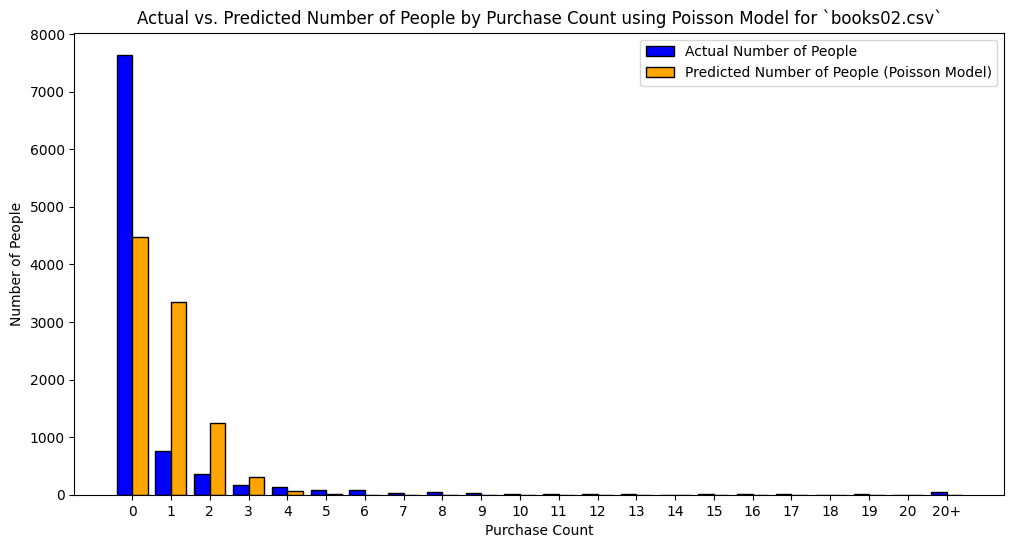

In [208]:
# Plotting the side-by-side bar chart for actual vs predicted counts using df_comparison
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Width of the bars

# Plot bars for actual and predicted counts
ax.bar(df_comparison['Purchase Count'] - bar_width/2,
       df_comparison['Actual Number of People'],
       bar_width,
       color='blue',
       edgecolor='black',
       label='Actual Number of People')

ax.bar(df_comparison['Purchase Count'] + bar_width/2,
       df_comparison['Predicted Number of People'],
       bar_width,
       color='orange',
       edgecolor='black',
       label='Predicted Number of People (Poisson Model)')

# Labeling the chart
ax.set_xlabel('Purchase Count')
ax.set_ylabel('Number of People')
ax.set_title("Actual vs. Predicted Number of People by Purchase Count using Poisson Model for `books02.csv`")
ax.legend()

# Customizing x-ticks to include "20+"
ax.set_xticks(df_comparison['Purchase Count'])
ax.set_xticklabels([str(int(x)) if x < 21 else "20+" for x in df_comparison['Purchase Count']])

# Show plot
plt.show()

### 4. Develop an NBD model using `books01.csv`.



##### 1. Log Likelihood

In [209]:
# Prepare the data for modeling
purchases = np.array(df_books01['number_of_purchases'])
people = np.array(df_books01['number_of_people'])

# Define the Negative Log-Likelihood function for the NBD model
def NLL_nbd(params, purchases, people):
    # unpack parameters
    n, alpha = params # shape and scale parameters for gamma distribution
    (nb_r, nb_p) = (n, alpha / (alpha + 1)) # parameters in the negative binomial distribution

    # calculate log probabilities for all purchases at once
    log_prob = nbinom.logpmf(purchases, nb_r, nb_p, loc = 0)

    # calculate log-likelihood for each purchase count
    ll = people * log_prob

    # sum the negative log-likelihood
    nll = -np.sum(ll)

    return nll # return the negative log-likelihood


##### 2. Optimize

In [210]:
# Initial guesses for parameters
params = np.array((1, 1))  # Initial guess for n and alpha

# Perform MLE for n and alpha
nbd_result = minimize(NLL_nbd,  # Minimize the negative log-likelihood
                      args=(purchases, people),  # Input data
                      x0=params,  # Initial guess for n and alpha
                      bounds=[(0.000001, None), (0.000001, None)],  # Parameter bounds to keep positive
                      tol=1e-10,  # Convergence tolerance
                      options={'ftol': 1e-8})  # Fractional tolerance

##### 3. Find estimated parameters and maximum value of the log-likelihood

In [211]:
# MLE parameters
mle_params_nbd = nbd_result.x
print(f'Estimated n: {mle_params_nbd[0]}\nEstimated α: {mle_params_nbd[1]}')

# Maximum value of log-likelihood
mll_nbd = -nbd_result.fun
print(f'Maximum Log-Likelihood: {mll_nbd}')

Estimated n: 0.08134123396136632
Estimated α: 0.21923386982438395
Maximum Log-Likelihood: -8603.497947274142


### 5. Develop an NBD model using `books02.csv`.

##### 1. Log Likelihood

In [212]:
# Extract the required columns
purchases = df_books02['barnesandnoble_purchases'].values  # Number of purchases per user
people = np.ones(len(purchases))  # Number of people per record, assumed 1 per user

# Define the Negative Log-Likelihood function for the NBD model with vectorization
def NLL_nbd(params, purchases, people):
    n, alpha = params
    nb_r = n
    nb_p = alpha / (alpha + 1)

    # Vectorized log-likelihood calculation
    log_likelihood = people * nbinom.logpmf(purchases, nb_r, nb_p, loc=0)
    nll = -np.sum(log_likelihood)  # Total negative log-likelihood

    return nll

##### 2. Optimize

In [213]:
# Initial guesses for parameters
params = np.array((1, 1))  # Initial guess for n and alpha

# Perform MLE for n and alpha
nbd_result = minimize(NLL_nbd,  # Minimize the negative log-likelihood
                      args=(purchases, people),  # Input data
                      x0=params,  # Initial guess for n and alpha
                      bounds=[(0.000001, None), (0.000001, None)],  # Parameter bounds to keep positive
                      tol=1e-6,  # Relaxed tolerance
                      options={'ftol': 1e-6})  # Relaxed fractional tolerance



In [214]:
# MLE parameters
mle_params_nbd = nbd_result.x
print(f'Estimated n: {mle_params_nbd[0]}\nEstimated α: {mle_params_nbd[1]}')

# Maximum value of log-likelihood
mll_nbd = -nbd_result.fun
print(f'Maximum Log-Likelihood: {mll_nbd}')

Estimated n: 0.08134369580455275
Estimated α: 0.21924059408765337
Maximum Log-Likelihood: -8603.498208117298


##### 3. Find estimated parameters and maximum value of the log-likelihood

### b) Predict the number of people with 0, ..., 20, 20+ purchases based on the NBD model.

In [215]:
n_est = mle_params_nbd[0]
alpha_mle = mle_params_nbd[1]

# Calculate probability of success parameter p for the Negative Binomial
nb_p = alpha_mle / (alpha_mle + 1)

# Modify purchases to cap values above 20 to 21
purchases_modified = np.where(df_books02['barnesandnoble_purchases'] > 20, 21, df_books02['barnesandnoble_purchases'])

# Prepare data for analysis
people = purchases_modified
unique_counts = np.unique(people)
total_people = len(people)

# Calculate predicted counts using the Negative Binomial model with estimated parameters
predicted_counts = [total_people * nbinom.pmf(count, n_est, nb_p) for count in unique_counts]

# Calculate actual counts from data (with purchases > 20 grouped into 21)
actual_counts = [np.sum(people == count) for count in unique_counts]

# Create a DataFrame to compare actual and predicted counts
df_comparison2 = pd.DataFrame({
    'Purchase Count': unique_counts,
    'Actual Number of People': actual_counts,
    'Predicted Number of People': predicted_counts
})

df_comparison2


,Purchase Count,Actual Number of People,Predicted Number of People
0,0.0,7639,8219.833261
1,1.0,753,548.400061
2,2.0,362,243.187830
3,3.0,175,138.380524
4,4.0,126,87.431053
5,5.0,82,58.534169
6,6.0,74,40.658127
7,7.0,30,28.970731
8,8.0,48,21.032734
9,9.0,31,15.489856


#### c)  Explain how the predicted values are obtained using the case of 2 purchases (show your calculations).

In [216]:
# Retrieve predicted number of people with exactly 2 purchases
predicted_people_2_purchases = df_comparison2.loc[df_comparison['Purchase Count'] == 2, 'Predicted Number of People'].values[0]

print(f"Predicted number of people with exactly 2 purchases: {predicted_people_2_purchases}")


Predicted number of people with exactly 2 purchases: 243.18783009067354


Negative Binomial distribution PMF Formula

$
P(X = k) = \frac{\Gamma(n + k)}{\Gamma(n) \cdot k!} \cdot \left( \frac{\alpha}{\alpha+ 1} \right)^{n} \cdot \left( \frac{1}{\alpha + 1} \right)^k
$

Predict values of k = 2 exposures:
-  size parameter **n** (shape of distribution) = 0.96926 \: number of trials until (X=k)
- scale/ dispersion parameter **α** (spread or how much variance deviates from mean)
  - n = 0.0813
  - α = 0.2192


$P(X = 2) = 9451 \times \frac{Γ(0.0813 + 2)}{Γ(0.0813) \times 2!} \times \big(\frac{0.2192}{0.2192
 + 1}\big)^{0.08134} \times \big(\frac{1}{0.2192 + 1}\big)^{2} \approx 243.188$

#### d) Graph the original and predicted number of purchases.

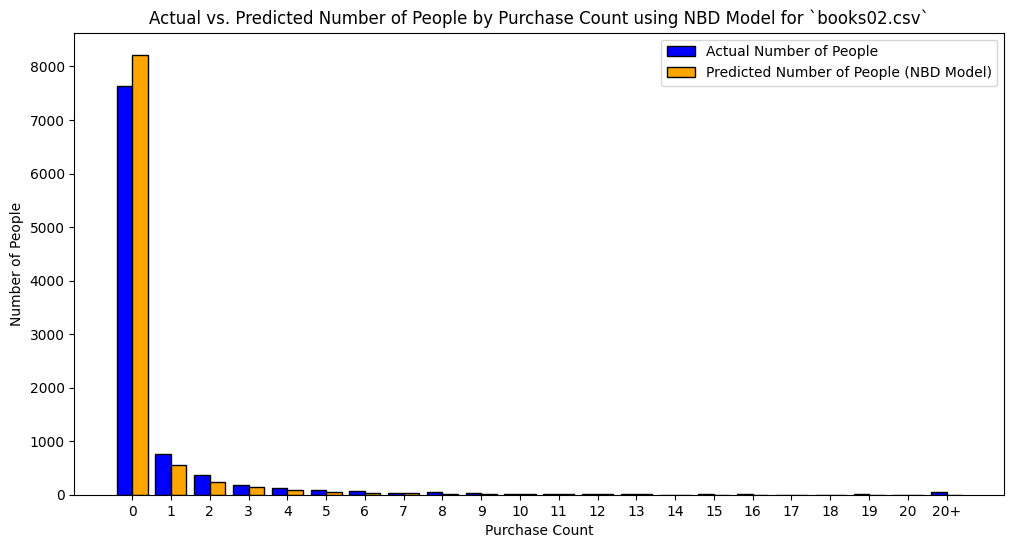

In [217]:
# Plotting the side-by-side bar chart for actual vs predicted counts using df_comparison
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Width of the bars

# Plot bars for actual and predicted counts
ax.bar(df_comparison2['Purchase Count'] - bar_width/2,
       df_comparison2['Actual Number of People'],
       bar_width,
       color='blue',
       edgecolor='black',
       label='Actual Number of People')

ax.bar(df_comparison2['Purchase Count'] + bar_width/2,
       df_comparison2['Predicted Number of People'],
       bar_width,
       color='orange',
       edgecolor='black',
       label='Predicted Number of People (NBD Model)')

# Labeling the chart
ax.set_xlabel('Purchase Count')
ax.set_ylabel('Number of People')
ax.set_title("Actual vs. Predicted Number of People by Purchase Count using NBD Model for `books02.csv`")
ax.legend()

# Customizing x-ticks to include "20+"
ax.set_xticks(df_comparison2['Purchase Count'])
ax.set_xticklabels([str(int(x)) if x < 21 else "20+" for x in df_comparison2['Purchase Count']])

# Show plot
plt.show()

### 6. Calculate the values of (i) reach, (ii) average frequency, and (iii) gross ratings points (GRPs) based on the NBD model

In [218]:
# Convert 'Purchase Count' to integer for consistency
df_comparison2['Purchase Count'] = df_comparison2['Purchase Count'].astype(int)

# Calculate reach as the proportion of the population making at least 1 purchase
reach_percentage = df_comparison2[df_comparison2['Purchase Count'] > 0]['Actual Number of People'].sum() / df_comparison2['Actual Number of People'].sum() * 100
print(f"Reach (proportion of population making at least 1 purchase) is {reach_percentage:.2f}%.")

# Calculate average frequency by dividing expected purchases by the reach proportion
expected_purchases = n_est/alpha_mle
average_frequency = expected_purchases / (reach_percentage / 100)
print(f"Average frequency (average number of purchases among those who purchased) is {average_frequency:.4f}.")

# Calculate GRPs by multiplying reach (in %) by average frequency
GRPs = reach_percentage * average_frequency
print(f"Gross rating points (average number of purchases per 100 people) is {GRPs:.4f}.")


Reach (proportion of population making at least 1 purchase) is 19.17%.
Average frequency (average number of purchases among those who purchased) is 1.9352.
Gross rating points (average number of purchases per 100 people) is 37.1025.


### 7. Identify all independent variables with missing values.

#### a) How many values are missing in each?
Drop any variable
with many missing values (specify how you are defining “many”). If the number of missing values is small (again,
specify how you are defining “small”), delete the rows involved. For the remaining variables (if any), replace the
missing values with the means of the corresponding variables. Explain the steps taken; report your code.

In [219]:
# Check for missing values in each column of df_books02
missing_values = df_books02.isnull().sum()

print(f'Number of Missing Values in Each Column\n{missing_values}')


Number of Missing Values in Each Column
userid                         0
education                   6914
region                        11
hhsz                           0
age                            1
income                         0
child                          0
race                           0
country                        0
barnesandnoble_purchases       0
dtype: int64


In [220]:
# get the total number of records
total_records = df_books02.shape[0]

# calculate the proportion of missing values in each category and format as a percentage
missing_values_percentage = ((df_books02.isnull().sum() / total_records)).apply(lambda x: f'{x:.2%}')

# display the result in a formatted way
print(f'Percentage of Missing Values\n{missing_values_percentage}')

Percentage of Missing Values
userid                       0.00%
education                   73.16%
region                       0.12%
hhsz                         0.00%
age                          0.01%
income                       0.00%
child                        0.00%
race                         0.00%
country                      0.00%
barnesandnoble_purchases     0.00%
dtype: object




    - Drop education because 73.16% of the values are missing.
    - Remove rows with missing values in region and age columns.



In [221]:
# drop education variable
df_books03 = df_books02.copy()
df_books03 = df_books03.drop('education', axis=1)

# drop rows with missing values in region and age columns
df_books03 = df_books03.dropna(subset=['region', 'age'])

df_books03.head()

,userid,region,hhsz,age,income,child,race,country,barnesandnoble_purchases
0,11443031,1.0,2,11.0,4,1,1,0,0.0
1,11519009,2.0,3,5.0,3,1,2,0,0.0
2,11550824,4.0,3,6.0,7,1,1,1,0.0
3,12650861,1.0,5,7.0,6,1,1,0,12.0
4,12856796,2.0,1,6.0,1,0,1,0,0.0


In [222]:
# Re check for missing values in each column of df_books02
missing_values = df_books03.isnull().sum()

print(f'Number of Missing Values in Each Column\n{missing_values}')

Number of Missing Values in Each Column
userid                      0
region                      0
hhsz                        0
age                         0
income                      0
child                       0
race                        0
country                     0
barnesandnoble_purchases    0
dtype: int64


### 8. Incorporate all the available customer characteristics and estimate all relevant parameters for Poisson regression using MLE.

#### a) Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant).

##### 1. Log-likelihood

In [223]:
# Optimized NLL function for Poisson regression
def NLL_poisson_reg_books2(params, X, y):
    lambda_0, *betas = params  # parameters for regression - lambda_0 and the remaining parameters in betas

    # Calculate lambda for each record using matrix multiplication and vectorized operations
    lambdas = lambda_0 * np.exp(X @ np.array(betas))

    # Calculate the log-likelihood for all records at once
    ll = poisson.logpmf(y, lambdas)

    # Sum negative log-likelihood over all records
    nll = -np.sum(ll)

    return nll  # return the negative log-likelihood


##### 2. Optimize

In [224]:
# Convert input data to numpy arrays
X = df_books03.copy()
X = np.array(X.drop(['userid', 'barnesandnoble_purchases'], axis=1))
y = np.array(df_books03['barnesandnoble_purchases'])

# Initial guess for parameters
params = np.ones(X.shape[1] + 1)

# Optimization using the minimize function
soln_poisson_reg_books2 = minimize(
    NLL_poisson_reg_books2,  # minimize the negative log-likelihood (equivalent to maximizing the log-likelihood)
    args=(X, y),  # input parameters (not to be altered by the solver)
    x0=params,  # initial guess for parameters
    bounds=[(0.000001, None)] + [(None, None)] * X.shape[1],  # bounds for decision variables
    tol=1e-10,  # convergence tolerance
    options={'ftol': 1e-8}  # fractional tolerance
)

##### 3. Find estimated parameters and maximum value of the log-likelihood

In [225]:
# MLE parameters
mle_lambda0_poisson_reg_books2, *mle_betas_poisson_reg_books2 = soln_poisson_reg_books2.x
print(f'Estimated lambda0: {mle_lambda0_poisson_reg_books2}')
for x, beta in enumerate(mle_betas_poisson_reg_books2):
    print(f'Estimated beta{x+1}: {beta}')

# Maximum value of log-likelihood
mll_poisson_reg_books2 = -soln_poisson_reg_books2.fun
print(f'Maximum Log-Likelihood: {mll_poisson_reg_books2}')

Estimated lambda0: 0.9501989758828293
Estimated beta1: -0.10226867505485861
Estimated beta2: -0.01541726108712694
Estimated beta3: 0.025004990669129066
Estimated beta4: 0.014953485232429837
Estimated beta5: 0.07438258247151501
Estimated beta6: -0.20722496667283374
Estimated beta7: -0.11955853847178027
Maximum Log-Likelihood: -18819.050407077935


#### b)  What are the managerial takeaways – which customer characteristics seem to be important?

Please see report

####c) Predict the number of people with 0, ..., 20, 20+ purchases based on the Poisson regression.

In [226]:
def predict_poisson_reg_books2(params, X, y):
  # unpack parameters
  lambda_0, *betas = params # lambda_0 and the remaining parameters in betas

  # assume each group has m independent individuals with lambda_i, the expected number of people with k purchases is m * p(x = k | lambda_i)
  # assume each record is a separate group, then the expected number of people with k purchases is p(x = k | lambda_i)
  # calculate p(x = k) for each lambda_i and sum up to get the expected number of people with k purchases

  # calculate lambda for each record using matrix multiplication
  lambdas = lambda_0 * np.exp(X @ np.array(betas))

  # get unique values of y to calculate probabilities for each unique count
  unique_counts = np.unique(y)

  # create a PMF matrix for each unique count k across all samples
  pmf_matrix = np.array([
      poisson.pmf(unique_counts, lambda_i) for lambda_i in lambdas])

  # sum probabilities across all samples for each k value
  pred = np.sum(pmf_matrix, axis = 0) # sum along the samples (axis = 0) for each unique k

  # sort dictionary by visit count
  pred_dict = dict(zip(unique_counts, pred))
  pred_dict = dict(sorted(pred_dict.items()))

  return pred_dict

# make predictions
pred_poisson_reg_books2 = predict_poisson_reg_books2(soln_poisson_reg_books2.x, X, y) # make predictions

In [227]:
# create a dataframe to store actual counts
actual_df = df_books03.groupby('barnesandnoble_purchases')['userid'].count().reset_index()
actual_df.columns = ['NumberofPurchases', 'ActualCustomerCount']

# create a dataframe to store predicted counts
pred_df = pd.DataFrame({'NumberofPurchases': list(pred_poisson_reg_books2.keys()),
                        'PredictedCustomerCount': list(pred_poisson_reg_books2.values())})

# merge actual and predicted counts on NumberofPurchases
books2_poisson_reg = pd.merge(actual_df, pred_df, on = 'NumberofPurchases', how = 'outer').fillna(0)

# combine groups with number of purchases > 20
books2_poisson_reg_combined = books2_poisson_reg.copy()
books2_poisson_reg_combined.loc[books2_poisson_reg_combined['NumberofPurchases'] > 20, 'NumberofPurchases'] = 21
books2_poisson_reg_combined = books2_poisson_reg_combined.groupby('NumberofPurchases').sum().reset_index()

# convert number of purchases into integer
books2_poisson_reg_combined['NumberofPurchases'] = books2_poisson_reg_combined['NumberofPurchases'].astype(int)
books2_poisson_reg_combined

,NumberofPurchases,ActualCustomerCount,PredictedCustomerCount
0,0,7630,4.495302e+03
1,1,752,3.303588e+03
2,2,362,1.245068e+03
3,3,173,3.201947e+02
4,4,126,6.311537e+01
5,5,82,1.015801e+01
6,6,74,1.388718e+00
7,7,30,1.656679e-01
8,8,48,1.758271e-02
9,9,31,1.684407e-03


#### d) Explain how the predicted values are obtained using the case of 2 purchases (show your calculations).

In [228]:
# calculate estimated lambda_i's
mle_lambdas_poisson_reg_books2 = mle_lambda0_poisson_reg_books2 * np.exp(X @ np.array(mle_betas_poisson_reg_books2))

# predicted values for the case of 2 purchases
k = 2

# sum up the probabilities of 2 purchases for each lambda_i
pred_2_purchases_poisson_reg_books2 = np.sum(poisson.pmf(k, mle_lambdas_poisson_reg_books2, loc = 0))
print(f'The predicted number of people for the case of 2 purchases: {pred_2_purchases_poisson_reg_books2}.')

The predicted number of people for the case of 2 purchases: 1245.0676466099885.


Step-by-Step Calculation of P(X = 2) in Poisson Regression

1. **Calculate the Expected Count \( λi \)**

   For each observation \( i \), the expected count \(λi\) is given by:

   $$
   \lambda_i = \exp(\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \beta_3 x_{3,i} + \beta_4 x_{4,i} + \beta_5 x_{5,i} + \beta_6 x_{6,i} + \beta_7 x_{7,i})
   $$

   where:
   - λ0 ≈ 0.9502
   - β1 ≈ -0.1023
   - β2 ≈ -0.0154
   - β3 ≈ 0.0250
   - β4 ≈ 0.0150
   - β5 ≈ -0.0744
   - β6 ≈ -0.2072
   - β7 ≈ -0.1196

2. **Compute the Probability of Exactly 2 Exposures**

   We use the Poisson probability mass function (PMF) to compute the probability that each individual has exactly 2 exposures, given by:

   $$
   P(X = 2) = \frac{\lambda_i^2 \exp(-\lambda_i)}{2!}
   $$

3. **Calculate P(X = 2) Using the Poisson PMF**

   $$
   P(X = 2) ≈ 1245.068
   $$


#### d) Graph the original and predicted number of purchases.

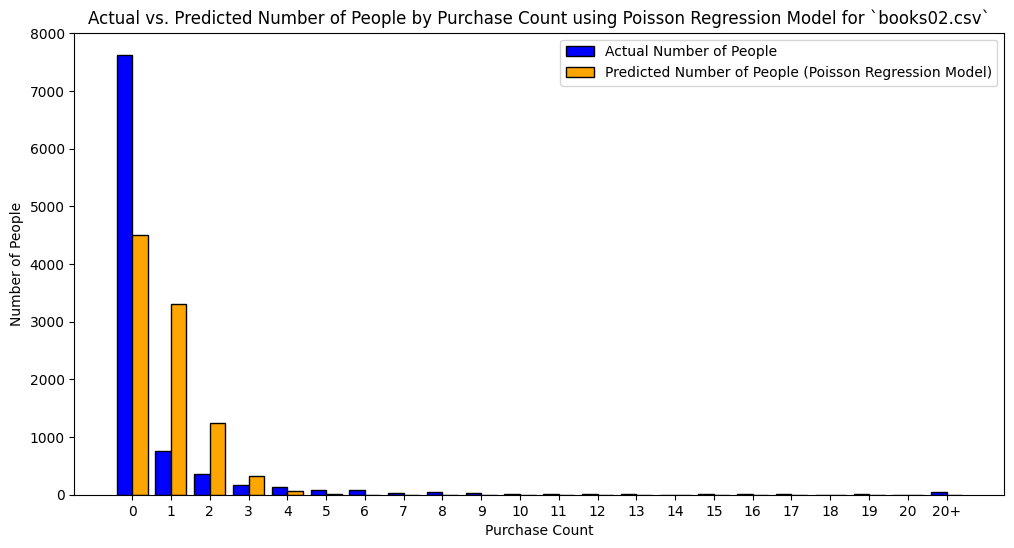

In [229]:
# Plotting the side-by-side bar chart for actual vs predicted counts using df_comparison
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Width of the bars

# Plot bars for actual and predicted counts
ax.bar(books2_poisson_reg_combined['NumberofPurchases'] - bar_width/2,
       books2_poisson_reg_combined['ActualCustomerCount'],
       bar_width,
       color='blue',
       edgecolor='black',
       label='Actual Number of People')

ax.bar(books2_poisson_reg_combined['NumberofPurchases'] + bar_width/2,
       books2_poisson_reg_combined['PredictedCustomerCount'],
       bar_width,
       color='orange',
       edgecolor='black',
       label='Predicted Number of People (Poisson Regression Model)')

# Labeling the chart
ax.set_xlabel('Purchase Count')
ax.set_ylabel('Number of People')
ax.set_title("Actual vs. Predicted Number of People by Purchase Count using Poisson Regression Model for `books02.csv`")
ax.legend()

# Customizing x-ticks to include "20+"
ax.set_xticks(books2_poisson_reg_combined['NumberofPurchases'])
ax.set_xticklabels([str(int(x)) if x < 21 else "20+" for x in books2_poisson_reg_combined['NumberofPurchases']])

# Show plot
plt.show()

### 9. Estimate all relevant parameters for NBD regression using MLE.

#### a) Report your code, the estimated parameters and
the maximum value of the log-likelihood (and any other information you believe is relevant). What are the
managerial takeaways – which customer characteristics seem to be important?

##### 1. Log-likelihood

In [230]:
# Define the optimized negative log-likelihood function for NBD regression
def NLL_nbd_reg_books2(params, X, y):
    # Extract parameters
    n, alpha, *betas = params  # n (dispersion), alpha (rate), and betas (coefficients)
    betas = np.array(betas)

    # Calculate exp(beta * X) for each record using matrix multiplication (vectorized)
    exp_betaX = np.exp(X @ betas)

    # Calculate log-likelihood components in a vectorized manner
    p1 = gammaln(n + y) - (gammaln(n) + gammaln(y + 1))  # gamma terms
    p2 = n * (np.log(alpha) - np.log(alpha + exp_betaX))
    p3 = y * (np.log(exp_betaX) - np.log(alpha + exp_betaX))

    # Sum the components to get the log-likelihood for each record
    ll = p1 + p2 + p3

    # Calculate the total negative log-likelihood
    nll = -np.sum(ll)

    return nll

##### 2. Optimize

In [231]:
# Set up the input data
X = np.array(df_books03.drop(['userid', 'barnesandnoble_purchases'], axis=1))  # Feature matrix
y = np.array(df_books03['barnesandnoble_purchases'])  # Target variable (number of purchases)

# Initial guess for parameters: n, alpha, and betas (1 dispersion + 1 alpha + number of features)
initial_params = np.ones(X.shape[1] + 2)

# Set bounds: no negative values for n and alpha
bounds = [(0.000001, None)] * 2 + [(None, None)] * X.shape[1]

# Perform MLE optimization
soln_nbd_reg_books2 = minimize(
    NLL_nbd_reg_books2,  # minimize the negative log-likelihood (equivalent to maximizing the log-likelihood)
    args=(X, y),  # input parameters (X and y)
    x0=initial_params,  # initial guess for parameters
    bounds=bounds,  # bounds for decision variables
    tol=1e-10,  # convergence tolerance
    options={'ftol': 1e-8}  # fractional tolerance
)

##### 3. Report estimated parameters and maximum value of the log-likelihood

In [232]:
# Extract optimized parameters
n_mle = soln_nbd_reg_books2.x[0]
alpha_mle = soln_nbd_reg_books2.x[1]
betas_mle = soln_nbd_reg_books2.x[2:]

# Print results
print(f'Estimated n (dispersion): {n_mle}')
print(f'Estimated alpha (rate): {alpha_mle}')
for i, beta in enumerate(betas_mle, start=1):
    print(f'Estimated beta_{i}: {beta}')
print(f'Maximum Log-Likelihood: {-soln_nbd_reg_books2.fun}')
mll_nbd_reg_books2 = -soln_nbd_reg_books2.fun

Estimated n (dispersion): 0.09803733094904478
Estimated alpha (rate): 0.10798926920865581
Estimated beta_1: -0.10333770616813463
Estimated beta_2: -0.008349375042909587
Estimated beta_3: 0.02837051419186888
Estimated beta_4: 0.01757916449943187
Estimated beta_5: 0.05804648877407603
Estimated beta_6: -0.2088436365984615
Estimated beta_7: -0.10259478164342996
Maximum Log-Likelihood: -8358.772481540207


#### b) Predict the number of people with 0, ..., 20, 20+ purchases based on the NBD regression

In [233]:
def predict_nbd_reg_books2(params, X, y):
  # unpack parameters
  n, alpha, *betas = params # n, alpha, and the remaining parameters in betas

  # assume each group has m independent individuals, the expected number of people with k purchases is m * p(x = k)
  # assume each record is a separate group, then the expected number of people with k purchases is p(x = k)
  # calculate p(x = k) for each record and sum up to get the expected number of people with k purchases

  # calculate exp(beta*X) for each record using matrix multiplication
  exp_betaX = np.exp(X @ np.array(betas))

  # get unique values of y to calculate probabilities for each unique count
  unique_counts = np.unique(y)

  # calculate the probability p for the negative binomial distribution
  p = alpha / (alpha + exp_betaX)

  # create a PMF matrix for each unique count k across all samples
  pmf_matrix = np.array([
      nbinom.pmf(unique_counts, n, p_i) for p_i in p])

  # sum probabilities across all samples for each k value
  pred = np.sum(pmf_matrix, axis = 0) # sum along the samples (axis = 0) for each unique k

  # sort dictionary by visit count
  pred_dict = dict(zip(unique_counts, pred))
  pred_dict = dict(sorted(pred_dict.items()))

  return pred_dict

# make predictions
pred_nbd_reg_books2 = predict_nbd_reg_books2(soln_nbd_reg_books2.x, X, y)
pred_nbd_reg_books2

{0.0: 7649.075331193544,
 1.0: 661.0080607599687,
 2.0: 320.0304632384062,
 3.0: 197.45365354369622,
 4.0: 134.97464969597974,
 5.0: 97.67684629656577,
 6.0: 73.30696094463674,
 7.0: 56.42908649291097,
 8.0: 44.256496939136944,
 9.0: 35.21245739978602,
 10.0: 28.338642328104104,
 11.0: 23.02015115887059,
 12.0: 18.845380987296842,
 13.0: 15.52932522886046,
 14.0: 12.86911336878001,
 15.0: 10.717000702311768,
 16.0: 8.963304352296229,
 17.0: 7.525260354174535,
 18.0: 6.339538455134692,
 19.0: 5.357089625487218,
 20.0: 4.539523071620515,
 21.0: 3.8565107740742928,
 23.0: 2.802302949123754,
 24.0: 2.396078121278236,
 27.0: 1.5136947172938455,
 28.0: 1.302910422098152,
 29.0: 1.1230626817669864,
 30.0: 0.9693296700133937,
 31.0: 0.8376938473566048,
 32.0: 0.7247973763603528,
 33.0: 0.6278256963323758,
 34.0: 0.5444133006677757,
 35.0: 0.4725671278954227,
 37.0: 0.3570993647799187,
 39.0: 0.2708144199709381,
 43.0: 0.1572645698888921,
 46.0: 0.10540985737582911,
 47.0: 0.09237061299242612,


In [234]:
# create a dataframe to store actual counts
actual_df = df_books03.groupby('barnesandnoble_purchases')['userid'].count().reset_index()
actual_df.columns = ['NumberofPurchases', 'ActualCustomerCount']

# create a dataframe to store predicted counts
pred_df = pd.DataFrame({'NumberofPurchases': list(pred_nbd_reg_books2.keys()),
                        'PredictedCustomerCount': list(pred_nbd_reg_books2.values())})

# merge actual and predicted counts on NumberofPurchases
books2_nbd_reg = pd.merge(actual_df, pred_df, on = 'NumberofPurchases', how = 'outer').fillna(0)

# combine groups with number of purchases > 20
books2_nbd_reg_combined = books2_nbd_reg.copy()
books2_nbd_reg_combined.loc[books2_nbd_reg_combined['NumberofPurchases'] > 20, 'NumberofPurchases'] = 21
books2_nbd_reg_combined = books2_nbd_reg_combined.groupby('NumberofPurchases').sum().reset_index()

# convert number of purchases into integer
books2_nbd_reg_combined['NumberofPurchases'] = books2_nbd_reg_combined['NumberofPurchases'].astype(int)
books2_nbd_reg_combined

,NumberofPurchases,ActualCustomerCount,PredictedCustomerCount
0,0,7630,7649.075331
1,1,752,661.008061
2,2,362,320.030463
3,3,173,197.453654
4,4,126,134.974650
5,5,82,97.676846
6,6,74,73.306961
7,7,30,56.429086
8,8,48,44.256497
9,9,31,35.212457


#### c) Explain how the predicted value are obtained using the case of 2 purchases

In [235]:
# Optimized parameters from the NBD regression
params = soln_nbd_reg_books2.x  # Optimized parameters from previous solution
target_count = 2  # Target purchase count

# Feature matrix X (your dataset without target variable)
# Assuming X is already defined in your environment

# Calculate exp(beta*X) for each record using matrix multiplication
exp_betaX = np.exp(X @ np.array(params[2:]))

# Calculate the probability parameter for the NBD
n = params[0]  # Dispersion
alpha = params[1]  # Rate
p = alpha / (alpha + exp_betaX)

# Calculate the PMF for the target count across all samples and sum the probabilities
predicted_probability_y_2 = np.sum([nbinom.pmf(target_count, n, p_i) for p_i in p])

predicted_probability_y_2

320.03046323840584

Step-by-Step Calculation of P(X = 2) in NBD Regression

1. **Calculate the Expected Count \(λi\)**

   For each observation \(i\), the expected count \(λi\) is given by:

   $$
   \mu_i = \exp(\beta_1 x_{1,i} + \beta_2 x_{2,i} + \beta_3 x_{3,i} + \beta_4 x_{4,i} + \beta_5 x_{5,i} + \beta_6 x_{6,i} + \beta_7 x_{7,i})
   $$

   where:
   - β1 ≈ -0.1033
   - β2 ≈ -0.0083
   - β3 ≈ 0.0284
   - β4 ≈ 0.0176
   - β5 ≈ 0.0573
   - β6 ≈ -0.2088
   - β7 ≈ -0.1026

2. **Compute the Probability of Exactly 2 Exposures**

   For each observation, we use the Negative Binomial probability mass function (PMF) to compute the probability that each individual has exactly 2 exposures, given by:

   $$
   P(X = 2) = \frac{\Gamma(n + 2)}{\Gamma(n) \times 2!} \times \big(\frac{\alpha}{\alpha + \mu_i}\big)^{n} \times \big(\frac{\mu_i}{\alpha + \mu_i}\big)^{2}
   $$
   
   where:
   - n = 0.0980
   - α = 0.1080

3. **Calculate P(X = 2) by Summation**

   We then sum up all the probabilities of exactly 2 exposures across all observations.
   $$
   P(X = 2) ≈ 320.030
   $$


#### d) Graph

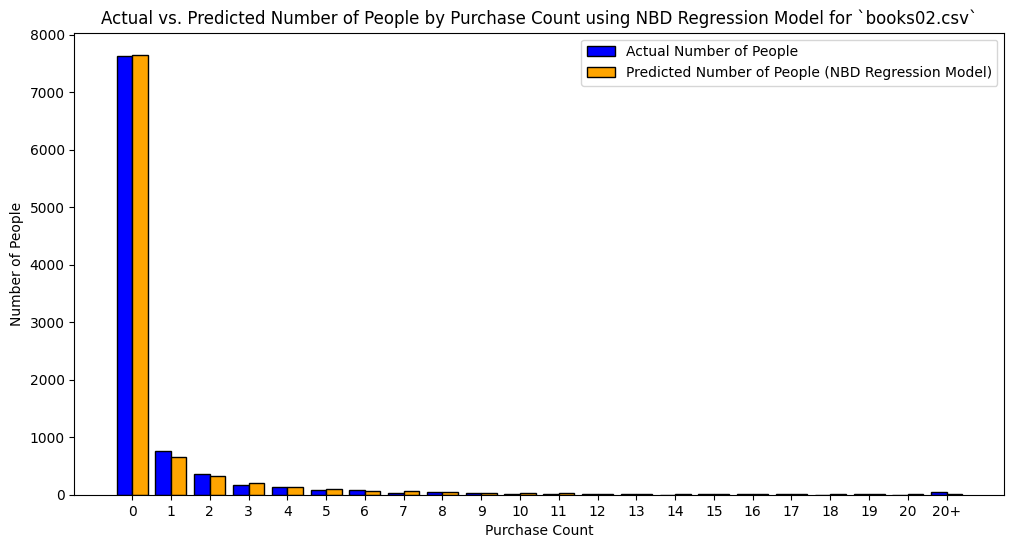

In [236]:
# Plotting the side-by-side bar chart for actual vs predicted counts using df_comparison
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Width of the bars

# Plot bars for actual and predicted counts
ax.bar(books2_nbd_reg_combined['NumberofPurchases'] - bar_width/2,
       books2_nbd_reg_combined['ActualCustomerCount'],
       bar_width,
       color='blue',
       edgecolor='black',
       label='Actual Number of People')

ax.bar(books2_nbd_reg_combined['NumberofPurchases'] + bar_width/2,
       books2_nbd_reg_combined['PredictedCustomerCount'],
       bar_width,
       color='orange',
       edgecolor='black',
       label='Predicted Number of People (NBD Regression Model)')

# Labeling the chart
ax.set_xlabel('Purchase Count')
ax.set_ylabel('Number of People')
ax.set_title("Actual vs. Predicted Number of People by Purchase Count using NBD Regression Model for `books02.csv`")
ax.legend()

# Customizing x-ticks to include "20+"
ax.set_xticks(books2_nbd_reg_combined['NumberofPurchases'])
ax.set_xticklabels([str(int(x)) if x < 21 else "20+" for x in books2_nbd_reg_combined['NumberofPurchases']])

# Show plot
plt.show()

### 10. Evaluate all the models developed using the log-likelihood ratio, AIC, and BIC.

What are your recommendations on which model to use based on each of these criteria? Are the recommendations consistent? Explain why you are
recommending the model you have selected. Are there any significant differences among the results from the
models? If so, what exactly are these differences? Discuss what you believe could be causing the differences.

In [237]:
# create a summary dataframe to store relevant metrics
summary = pd.DataFrame({'Model': ['Poisson', 'NBD', 'Poisson Regression', 'NBD Regression'],
                        'Number of Parameters': [len(x) for x in [result3.x, nbd_result.x, soln_poisson_reg_books2.x,soln_nbd_reg_books2.x ]],
                        'Maximum Log-Likelihood': [max_log_likelihood, mll_nbd, mll_poisson_reg_books2, mll_nbd_reg_books2]
                        })

In [238]:
# define specific pairs to compare
pairs_to_compare = [
    ('Poisson', 'NBD'),
    ('Poisson', 'Poisson Regression'),
    ('Poisson Regression', 'NBD Regression'),
    ('NBD', 'NBD Regression')
]

# initialize an empty list to store log-likelihood ratios
results = []

# iterate through all possible pairs of models
for model1, model2 in pairs_to_compare:
  # get the log-likelihoods and number of parameters for the 2 models
  ll1 = summary.loc[summary['Model'] == model1, 'Maximum Log-Likelihood'].values[0]
  ll2 = summary.loc[summary['Model'] == model2, 'Maximum Log-Likelihood'].values[0]

  df1 = summary.loc[summary['Model'] == model1, 'Number of Parameters'].values[0]
  df2 = summary.loc[summary['Model'] == model2, 'Number of Parameters'].values[0]

  # log-likelihood ratio
  lr_stat = 2 * (ll2 - ll1)

  # calculate difference in df
  df_diff = abs(df2 - df1)

  # calculate p-value from chi-squared distribution
  p_value = 1 - chi2.cdf(lr_stat, df_diff)
  p_value = round(p_value, 5)

  # append the result
  results.append({
        'Simple Model': model1,
        'Complex Model': model2,
        'Log-Likelihood Ratio': lr_stat,
        'Degrees of Freedom Difference': df_diff,
        'Chi-Squared p-value': p_value})

# create a dataframe to store the pairwise results
comparison_df = pd.DataFrame(results)

comparison_df

,Simple Model,Complex Model,Log-Likelihood Ratio,Degrees of Freedom Difference,Chi-Squared p-value
0,Poisson,NBD,20636.840443,1,0.0
1,Poisson,Poisson Regression,205.736045,7,0.0
2,Poisson Regression,NBD Regression,20920.555851,1,0.0
3,NBD,NBD Regression,489.451453,7,0.0


In [239]:
# append the dataframe with AIC and BIC
summary['AIC'] = 2 * summary['Number of Parameters'] - 2 * summary['Maximum Log-Likelihood']
summary['BIC'] = np.log(np.sum(df_books01['number_of_people'])) * summary['Number of Parameters'] - 2 * summary['Maximum Log-Likelihood']

summary.round(2)

,Model,Number of Parameters,Maximum Log-Likelihood,AIC,BIC
0,Poisson,1,-18921.92,37845.84,37852.99
1,NBD,2,-8603.50,17211.00,17225.30
2,Poisson Regression,8,-18819.05,37654.10,37711.33
3,NBD Regression,9,-8358.77,16735.54,16799.93


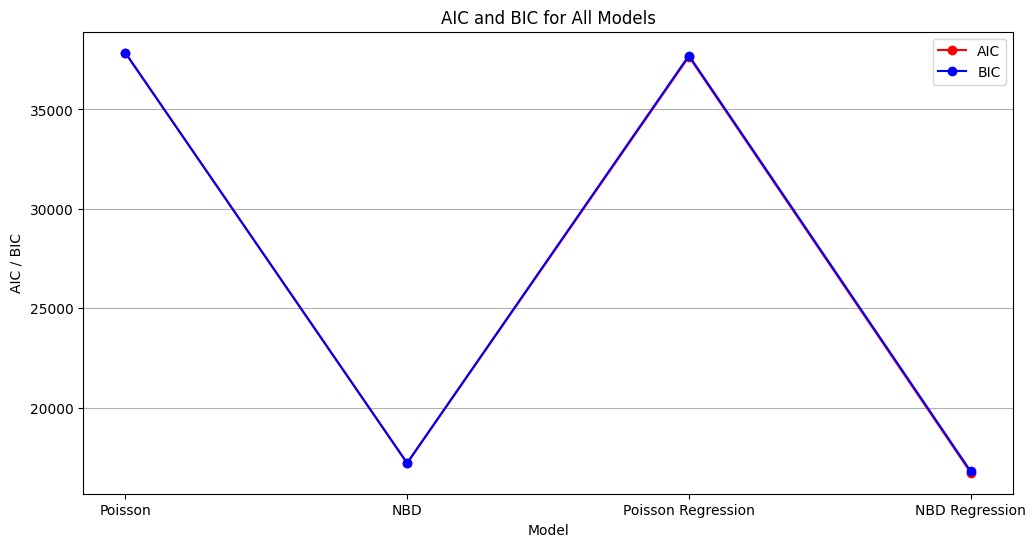

In [240]:
plt.figure(figsize=(12,6))
plt.plot(summary['AIC'], color = 'red', marker = 'o', label = 'AIC')
plt.plot(summary['BIC'], color = 'blue', marker = 'o', label = 'BIC')
plt.xticks(ticks = np.arange(len(summary['Model'])),labels = summary['Model'])
plt.xlabel('Model')
plt.ylabel('AIC / BIC')
plt.legend()
plt.grid(axis = 'y')
plt.title('AIC and BIC for All Models')
plt.show()

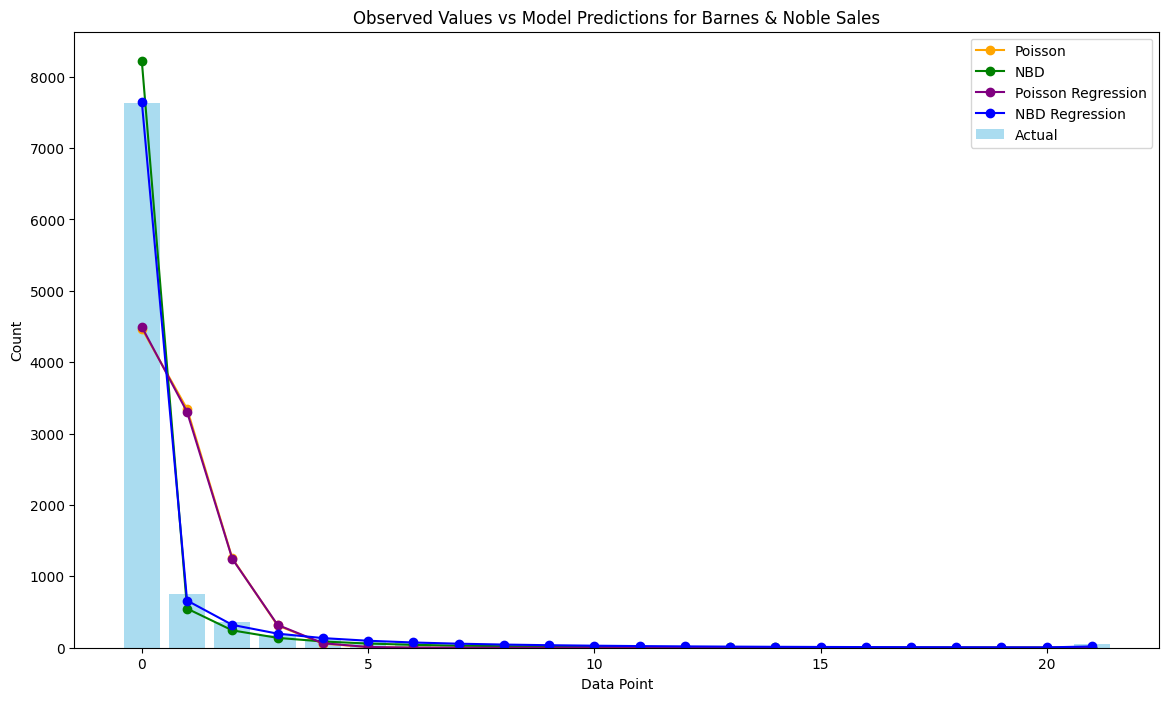

In [241]:
import matplotlib.pyplot as plt

# Observed values
observed_values = books2_nbd_reg_combined['ActualCustomerCount'].values

# Predictions from different models
poisson_predictions = df_comparison['Predicted Number of People'].values
nbd_predictions = df_comparison2['Predicted Number of People'].values
poisson_regression_predictions = books2_poisson_reg_combined['PredictedCustomerCount'].values
nbd_regression_predictions = books2_nbd_reg_combined['PredictedCustomerCount'].values

# Set up the x-axis for 10 data points
x = np.arange(len(observed_values))

# Plot observed values as a bar chart
plt.figure(figsize=(14,8))
plt.bar(x, observed_values, color='skyblue', label='Actual', alpha=0.7)

# Plot predictions from each model as line graphs
plt.plot(x, poisson_predictions, color='orange', marker='o', linestyle='-', label='Poisson')
plt.plot(x, nbd_predictions, color='green', marker='o', linestyle='-', label='NBD')
plt.plot(x, poisson_regression_predictions, color='purple', marker='o', linestyle='-', label='Poisson Regression')
plt.plot(x, nbd_regression_predictions, color='blue', marker='o', linestyle='-', label='NBD Regression')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Count')
plt.title('Observed Values vs Model Predictions for Barnes & Noble Sales')
plt.legend()

# Show the plot
plt.show()
